In [ ]:

"""
Script para analizar y comparar salidas de MITgcm
con bahía y sin bahía, empleando netCDF vía MITgcmutils / xarray.
 
Incluye:
1. Lectura de archivos netCDF con MITgcmutils.
2. Funciones para graficar:
   - Batimetría (vista completa y zoom).
   - Velocidades superficiales y verticales.
   - Diferencias entre "con bahía" y "sin bahía".
   - Corte vertical (perfil) de la velocidad vertical.
3. Funciones para generar animaciones de variables (Eta, W, etc.).

Requerimientos:
- numpy, matplotlib, cmocean, MITgcmutils, xarray, seaborn
"""

import numpy as np
import matplotlib.pyplot as plt
import cmocean as cmo
import seaborn as sns
import xarray as xr
import MITgcmutils as MIT
import gsw 

from matplotlib.animation import FuncAnimation

# Ajustar el estilo general de seaborn (opcional)
sns.set_context('notebook')


# --------------------------------------------------------------------
# 1. Lectura de archivos netCDF (con y sin bahía) y carga de variables
# --------------------------------------------------------------------
def cargar_datos_mitgcm(outdir_bay, outdir_nobay, use_wildcard=False):
    """
    Carga archivos netCDF de MITgcm (con bahía y sin bahía) usando MITgcmutils.
    Devuelve un diccionario con:
        nc_bay   : referencias a 'state' con bahía
        nc_nobay : referencias a 'state' sin bahía
        gr_bay   : referencias a 'grid' con bahía
        time     : arreglo de tiempos (segundos)
    """
    # Escoger el patrón según el booleano
    if use_wildcard:
        pattern_bay   = 'state.*.t*.nc'
        pattern_nobay = 'state.*.t*.nc'
    else:
        pattern_bay   = 'state.0000002880.t*.nc'
        pattern_nobay = 'state.0000002880.t*.nc'

    # Cargar (con bahía)
    nc_bay = MIT.mnc_files(outdir_bay + pattern_bay)
    gr_bay = MIT.mnc_files(outdir_bay + 'grid.t*.nc')

    # Cargar (sin bahía)
    nc_nobay = MIT.mnc_files(outdir_nobay + pattern_nobay)

    # Extraer el vector de tiempo de uno de los archivos (asumimos que con bahía hay al menos uno)
    time = nc_bay.variables['T'][:]  # en segundos

    return {
        'nc_bay': nc_bay,
        'nc_nobay': nc_nobay,
        'gr_bay': gr_bay,
        'time': time
    }


# --------------------------------------------------------------------
# 2. Función para graficar la batimetría en vista completa y zoom
# --------------------------------------------------------------------
def plot_bathymetry_full_zoom(gr, X_sym=150, Y_cut=420):
    """
    Dibuja la batimetría (depth) en dos subplots:
    1) Vista completa
    2) Zoom en la región de interés

    Parámetros
    ----------
    gr : referencial netCDF (grid) con variables 'Depth', 'XC', 'YC', 'hFacC', etc.
    X_sym, Y_cut : definen el recorte para el zoom.
    """
    # Extraer variables de gr
    depth = gr.variables['Depth'][:]
    mask = np.ma.getmask(np.ma.masked_values(depth, 0))  # mascara donde depth=0
    XC = gr.variables['XC'][:]
    YC = gr.variables['YC'][:]

    # Definir límites para la escala de color
    vmin = np.nanmin(-depth)
    vmax = np.nanmax(-depth)

    # Figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Subplot 1 (vista completa)
    pc1 = ax1.contourf(
        XC[0, :],
        YC[:, 0],
        np.ma.masked_array(-depth, mask=mask),
        cmap=cmo.cm.deep_r,
        vmin=vmin, vmax=vmax
    )
    ax1.set_aspect('equal')
    ax1.set_facecolor('tan')
    ax1.set_title('Bathymetry (vista completa)')

    # Subplot 2 (zoom)
    X_axis_idx = len(XC[0, :]) // 2  # Centro
    pc2 = ax2.contourf(
        XC[0, X_axis_idx - X_sym : X_axis_idx + X_sym],
        YC[-Y_cut:, 0],
        np.ma.masked_array(
            -depth[-Y_cut:, X_axis_idx - X_sym : X_axis_idx + X_sym],
            mask=mask[-Y_cut:, X_axis_idx - X_sym : X_axis_idx + X_sym]
        ),
        cmap=cmo.cm.deep_r,
        vmin=vmin, vmax=vmax
    )
    ax2.set_aspect('equal')
    ax2.set_facecolor('tan')
    ax2.set_title('Bathymetry (zoom)')

    # Barra de color global
    cbar = fig.colorbar(pc1, ax=[ax1, ax2], label='depth (m)')
    #plt.tight_layout()
    plt.show()


# --------------------------------------------------------------------
# 3. Funciones para graficar variables instantáneas (U, V, W, Eta, etc.)
# --------------------------------------------------------------------
def plot_variable_2d(var2d, X, Y, mask, time_val, varname="Var", units="", 
                     cmap=cmo.cm.balance, vmin=None, vmax=None):
    """
    Grafica una variable 2D (ej. W, Eta) en un pcolormesh, con contorno de la máscara.
    Parámetros
    ----------
    var2d    : np.ndarray 2D con la variable a graficar
    X, Y     : coordenadas (2D o 1D) del dominio
    mask     : máscara para contornear la región de tierra (u otras)
    time_val : valor de tiempo (s, o lo que sea) para el título
    varname  : nombre de la variable (para el título)
    units    : unidades (ej. m/s)
    cmap     : colormap
    vmin,vmax: límites de color
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    mesh = ax.pcolormesh(X, Y, var2d, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(mesh, ax=ax, label=f"{varname} ({units})")

    # Contorno de la máscara
    ax.contour(X, Y, mask, colors='black', linewidths=2, linestyles='--')

    # Etiquetas y título
    ax.set_title(f"{varname} a {time_val / 3600:.2f} h")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


def plot_surface_velocity(nc_bay, nc_nobay, gr, time_index, subtract=False):
    """
    Ejemplo: grafica la velocidad superficial (U y V) para un instante dado (time_index).
    Si subtract=True, grafica la diferencia (bahía - sin bahía).
    """
    # Extraer coordenadas y máscara
    Xp1 = gr.variables['Xp1'][:]
    YC = gr.variables['YC'][:]
    mask = np.ma.getmask(np.ma.masked_values(gr.variables['Depth'][:], 0))
    tval = nc_bay.variables['T'][time_index]

    U_bay = nc_bay.variables['U'][time_index, 0, :, :]
    V_bay = nc_bay.variables['V'][time_index, 0, :, :]
    U_nobay = nc_nobay.variables['U'][time_index, 0, :, :]
    V_nobay = nc_nobay.variables['V'][time_index, 0, :, :]

    if subtract:
        U_plot = U_bay - U_nobay
        varname = "U (bahía - sin bahía)"
    else:
        U_plot = U_bay
        varname = "U (con bahía)"

    plot_variable_2d(
        U_plot, Xp1, YC[:, 0], mask, tval,
        varname=varname, units="m/s",
        cmap=cmo.cm.balance
    )


# --------------------------------------------------------------------
# 4. Funciones para animaciones
# --------------------------------------------------------------------
def animar_2d_variable(nc_bay, nc_nobay, gr, varname='Eta', level=0, 
                       subtract=False, outname="anim_eta.mp4",
                       vmin=-0.005, vmax=0.005, fps=2):
    """
    Crea y guarda una animación 2D de la variable 'varname' a lo largo del tiempo.
    Ej. animar_2d_variable(nc_bay, nc_nobay, gr, varname='Eta', subtract=True, outname="eta_diff.mp4")
    level se usa para 3D (eje Z): p.ej. W[time, level, y, x].
    subtract=True => (bahía - sin bahía).
    """
    # Coordenadas
    X = gr.variables['XC'][0, :]
    Y = gr.variables['YC'][:, 0]
    mask = np.ma.getmask(np.ma.masked_values(gr.variables['Depth'][:], 0))

    time_data = nc_bay.variables['T'][:]  # Asumimos tiempos iguales
    # Frame inicial
    data_bay_init = nc_bay.variables[varname][0]
    if data_bay_init.ndim == 3:
        data_bay_init = data_bay_init[level, :, :]
    data_nobay_init = nc_nobay.variables[varname][0]
    if data_nobay_init.ndim == 3:
        data_nobay_init = data_nobay_init[level, :, :]

    # Setup figura
    fig, ax = plt.subplots(figsize=(8, 6))
    # Primer frame
    if subtract:
        data_init = data_bay_init - data_nobay_init
        title_str = f"{varname} (bay - noBay)"
    else:
        data_init = data_bay_init
        title_str = f"{varname} (con bahía)"

    mesh = ax.pcolormesh(X, Y, data_init, cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mesh, ax=ax, label=f"{varname}")
    ax.contour(X, Y, mask, colors='black', linewidths=2, linestyles='--')
    ax.set_aspect('equal')
    ax.set_title(f"{title_str} t=0 h")
    plt.tight_layout()

    def update(frame):
        data_bay = nc_bay.variables[varname][frame]
        if data_bay.ndim == 3:
            data_bay = data_bay[level, :, :]

        data_nobay = nc_nobay.variables[varname][frame]
        if data_nobay.ndim == 3:
            data_nobay = data_nobay[level, :, :]

        if subtract:
            data = data_bay - data_nobay
        else:
            data = data_bay

        mesh.set_array(data.ravel())
        ax.set_title(f"{title_str} t={time_data[frame]/3600:.2f} h")
        return mesh,

    anim = FuncAnimation(fig, update, frames=range(len(time_data)), blit=True)
    anim.save(outname, writer="ffmpeg", fps=fps)
    plt.show()





In [2]:
# --------------------------------------------------------------------
# 5. Función para graficar Eta con corte zoom
# --------------------------------------------------------------------


def animar_2d_variable_zoom(
    nc_bay,
    nc_nobay,
    gr,
    varname='Eta',
    level=0,
    subtract=False,
    outname="anim_eta_zoom.mp4",
    vmin=-0.005,
    vmax=0.005,
    fps=2,
    # Parámetros para el zoom
    X_sym=150,      # número de puntos a la izquierda/derecha del centro en X
    Y_cut=420,      # número de puntos a recortar desde la parte inferior del dominio
):
    """
    Crea y guarda una animación 2D con zoom de la variable 'varname' a lo largo del tiempo.
    Si varname es 3D, se toma el índice 'level' en Z: varname[time, level, y, x].
    subtract=True => (con bahía - sin bahía).

    Zoom:
      - X se recorta ±X_sym alrededor del centro del dominio
      - Y se recorta las últimas Y_cut filas (p.ej. para ver 'la parte de arriba')
    
    Parámetros
    ----------
    nc_bay : netCDF de MITgcm (con bahía).
    nc_nobay : netCDF de MITgcm (sin bahía).
    gr : netCDF grid (para extraer coordenadas, máscaras).
    varname : str, nombre de la variable (ej. 'Eta', 'W', 'U', etc.).
    level : int, nivel vertical (si la variable es 3D).
    subtract : bool, si True se anima la diferencia (bay - noBay).
    outname : str, nombre de archivo mp4 a guardar.
    vmin, vmax : límites de la escala de color.
    fps : frames por segundo para la animación.
    X_sym : define cuántos puntos se toman a la izquierda/derecha del centro en X.
    Y_cut : cuántos puntos se recortan desde la parte inferior en Y (zoom).
    """

    # 1) Extraer coordenadas y máscara
    #    Nota: asumiendo que XC y YC son 2D y tienen la forma (ny, nx).
    XC = gr.variables['XC'][0, :]       # Eje X en la fila 0
    YC = gr.variables['YC'][:, 0]       # Eje Y en la columna 0
    mask_2d = np.ma.getmask(
        np.ma.masked_values(gr.variables['Depth'][:], 0)
    )  # mask donde depth==0
    time_data = nc_bay.variables['T'][:]  # Arreglo de tiempos (s)

    # Dimensión total en X
    nx = len(XC)
    # Centro en X
    X_axis_idx = nx // 2

    # Crear slices para hacer zoom
    # X: [X_axis_idx - X_sym : X_axis_idx + X_sym]
    # Y: [-Y_cut : ] => las últimas Y_cut filas
    x_slice = slice(X_axis_idx - X_sym, X_axis_idx + X_sym)
    y_slice = slice(-Y_cut, None)

    # 2) Leer primer frame para inicializar
    data_bay_init = nc_bay.variables[varname][0]
    if data_bay_init.ndim == 3:
        data_bay_init = data_bay_init[level, :, :]  # shape (ny, nx)
    data_bay_init_zoom = data_bay_init[y_slice, x_slice]

    data_nobay_init = nc_nobay.variables[varname][0]
    if data_nobay_init.ndim == 3:
        data_nobay_init = data_nobay_init[level, :, :]
    data_nobay_init_zoom = data_nobay_init[y_slice, x_slice]

    if subtract:
        data_init = data_bay_init_zoom - data_nobay_init_zoom
        title_str = f"{varname} (bay - noBay)"
    else:
        data_init = data_bay_init_zoom
        title_str = f"{varname} (con bahía)"

    # Recortar también las coordenadas y la máscara
    X_zoom = XC[x_slice]
    Y_zoom = YC[y_slice]
    mask_zoom = mask_2d[y_slice, x_slice]

    # 3) Crear la figura y eje
    fig, ax = plt.subplots(figsize=(8, 6))

    # 4) pcolormesh inicial
    mesh = ax.pcolormesh(
        X_zoom,
        Y_zoom,
        data_init,
        cmap=cmo.cm.balance,
        vmin=vmin,
        vmax=vmax
    )
    cbar = fig.colorbar(mesh, ax=ax, label=f"{varname}")
    ax.contour(
        X_zoom,
        Y_zoom,
        mask_zoom,
        colors='black',
        linewidths=2,
        linestyles='--'
    )
    ax.set_aspect('equal')
    ax.set_title(f"{title_str} t=0 h")
    plt.tight_layout()

    # 5) Función de actualización de cada frame
    def update(frame):
        data_bay = nc_bay.variables[varname][frame]
        if data_bay.ndim == 3:
            data_bay = data_bay[level, :, :]

        data_nobay = nc_nobay.variables[varname][frame]
        if data_nobay.ndim == 3:
            data_nobay = data_nobay[level, :, :]

        # Recortar a la zona de zoom
        data_bay_zoom = data_bay[y_slice, x_slice]
        data_nobay_zoom = data_nobay[y_slice, x_slice]

        if subtract:
            data_zoom = data_bay_zoom - data_nobay_zoom
        else:
            data_zoom = data_bay_zoom

        mesh.set_array(data_zoom.ravel())
        ax.set_title(f"{title_str} t={time_data[frame] / 3600:.2f} h")

        return mesh,

    # 6) Crear la animación
    anim = FuncAnimation(
        fig,
        update,
        frames=range(len(time_data)),
        blit=True
    )

    # 7) Guardar la animación y mostrar
    anim.save(outname, writer="ffmpeg", fps=fps)
    plt.show()

In [3]:
# Rutas a los outputs con y sin bahía
outdir_bay = '../run_expand/mnc_00*/'
outdir_nobay = '../run_expand_nobay/mnc_00*/'

# Cargar datos
data_dict = cargar_datos_mitgcm(outdir_bay, outdir_nobay, use_wildcard=True)
nc_bay = data_dict['nc_bay']
nc_nobay = data_dict['nc_nobay']
gr_bay = data_dict['gr_bay']
time = data_dict['time']

In [4]:
#muestra las variables disponibles
print("Variables disponibles en el archivo con bahía:")
for var in nc_bay.variables.keys():
    print(var)


Variables disponibles en el archivo con bahía:
T
iter
Xp1
Y
Z
U
X
Yp1
V
Temp
S
Eta
Zl
W


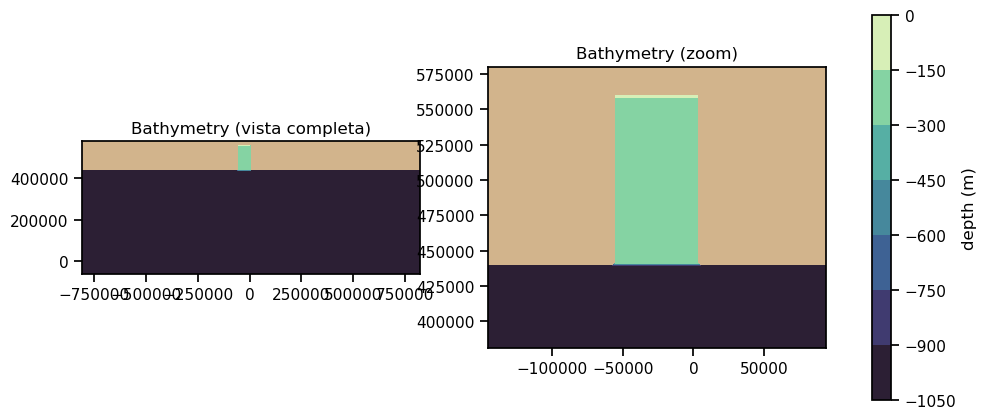

In [4]:
# 1) Graficar bathymetry (vista completa y zoom)
plot_bathymetry_full_zoom(gr_bay, X_sym=60, Y_cut=100)

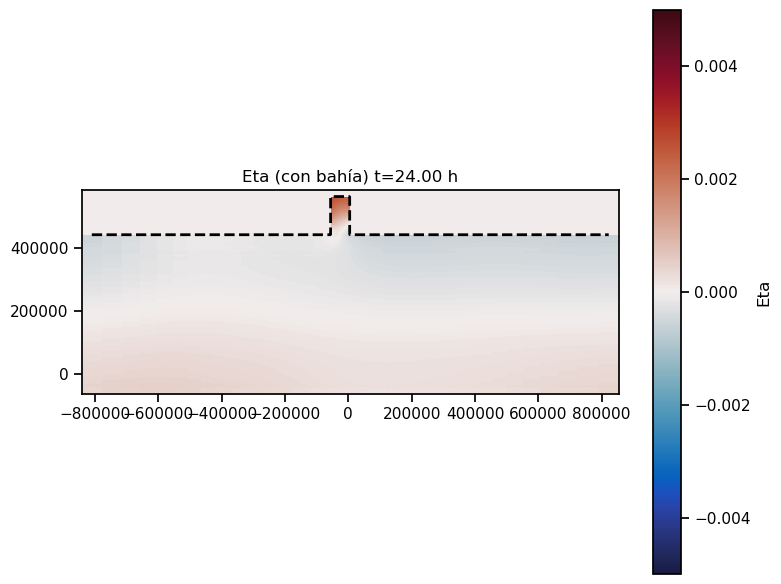

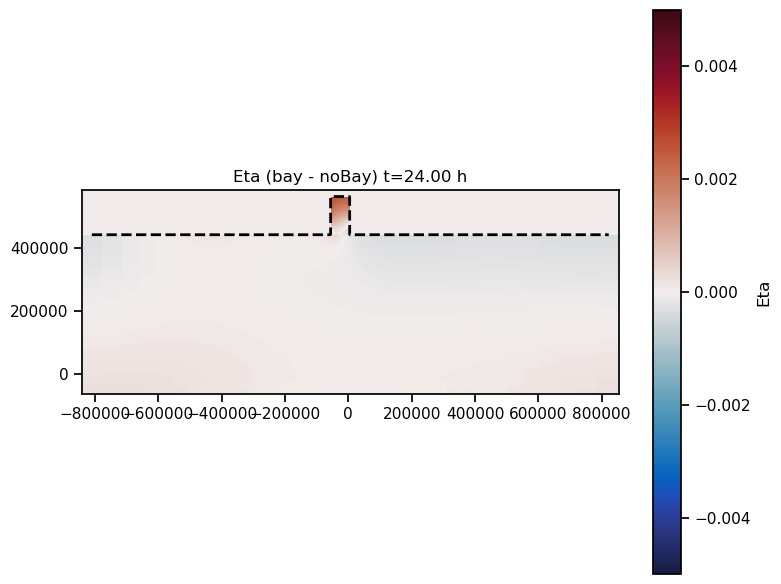

In [5]:
# 3) Animar Eta (superficie libre) con y sin bahía
animar_2d_variable(nc_bay, nc_nobay, gr_bay, varname='Eta', subtract=False, outname="eta_bay_sponge.mp4")
animar_2d_variable(nc_bay, nc_nobay, gr_bay, varname='Eta', subtract=True, outname="eta_diff_sponge.mp4")


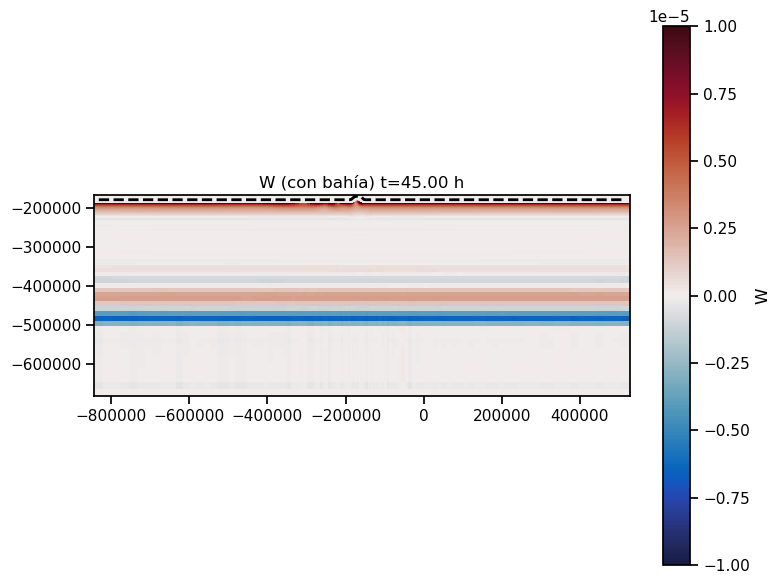

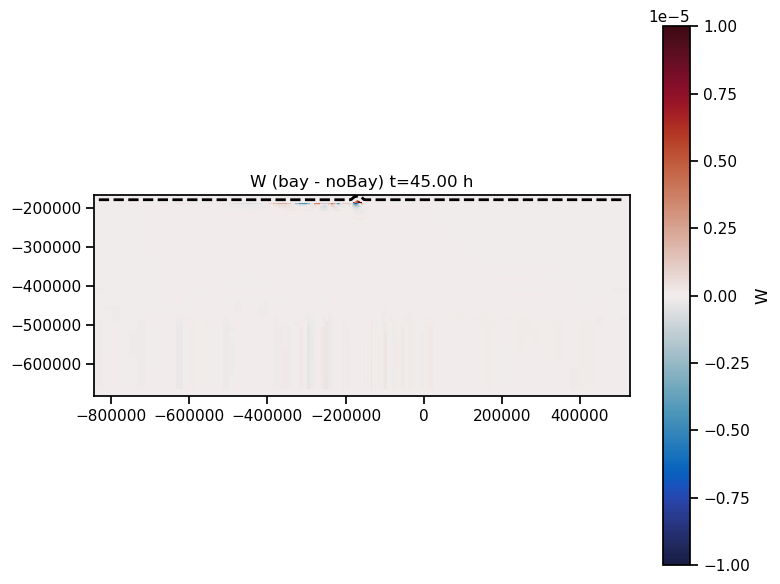

In [ ]:
# 4) Animar W a cierta profundidad (p.ej. W[ :,25,:,: ])
animar_2d_variable(nc_bay, nc_nobay, gr_bay, varname='W', level=25, subtract=False, outname="W_bay_sponge_2fase.mp4", vmin=-1e-5, vmax=1e-5)
animar_2d_variable(nc_bay, nc_nobay, gr_bay, varname='W', level=25, subtract=True, outname="W_diff_sponge_2fase.mp4", vmin=-1e-5, vmax=1e-5)

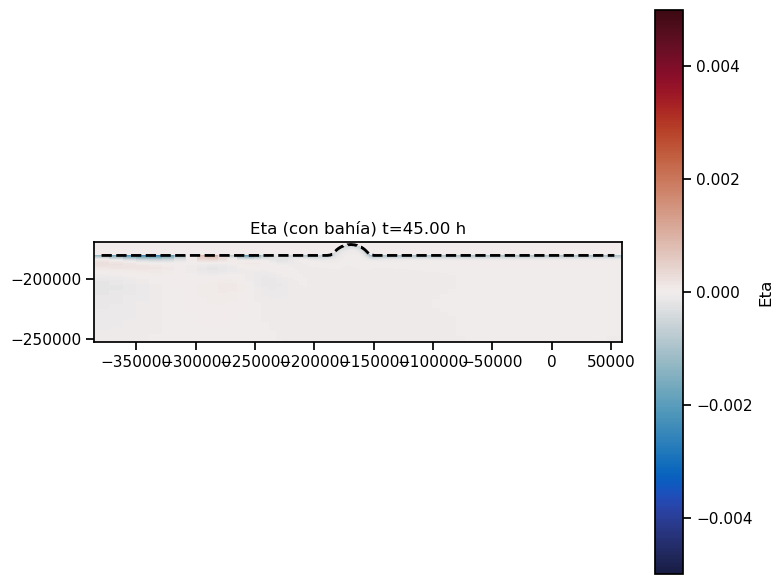

In [28]:
animar_2d_variable_zoom(nc_bay,nc_nobay,gr_bay, varname='Eta', level=0,
    subtract=False, outname="anim_eta_zoom_sponge.mp4", vmin=-0.005, vmax=0.005,
    fps=2,
    # Parámetros para el zoom
    X_sym=150,      # número de puntos a la izquierda/derecha del centro en X
    Y_cut=420,      # número de puntos a recortar desde la parte inferior del dominio
)

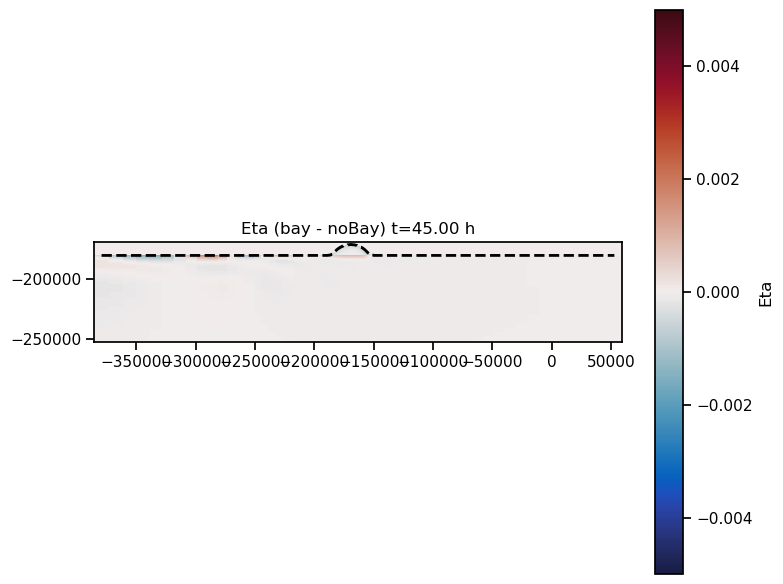

In [29]:
animar_2d_variable_zoom(nc_bay,nc_nobay,gr_bay, varname='Eta', level=0,
    subtract=True, outname="anim_eta_zoom_diff_sponge.mp4", vmin=-0.005, vmax=0.005,
    fps=2,
    # Parámetros para el zoom
    X_sym=150,      # número de puntos a la izquierda/derecha del centro en X
    Y_cut=420,      # número de puntos a recortar desde la parte inferior del dominio
)

In [30]:
### VIDEOS COMPARACIÓN ETHA

from moviepy import VideoFileClip, clips_array

# Rutas de los videos
video1_path = 'anim_eta_zoom_diff_sponge.mp4'
video2_path = 'anim_eta_zoom_diff.mp4'
#video2_path = 'animationEtha_diff.mp4'

# Cargar los videos
clip1 = VideoFileClip(video1_path)
clip2 = VideoFileClip(video2_path)

combined = clips_array([[clip1, clip2]])
combined.preview()

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [800, 600], 'bitrate': 10, 'fps': 2.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.19.100 libx264'}}], 'input_number': 0}], 'duration': 68.0, 'bitrate': 11, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [800, 600], 'video_bitrate': 10, 'video_fps': 2.0, 'video_duration': 68.0, 'video_n_frames': 136}
/opt/anaconda3/lib/python3.12/site-packages/imageio_ffmpeg/binaries/ffmpeg-macos-aarch64-v7.1 -i anim_eta_zoom_diff_sponge.mp4 -loglevel error -f image2pipe -vf scale=800:600 -sws_fla

In [22]:
def animar_perfil_w(
    nc_bay,
    nc_nobay,
    gr,
    time,
    subtract=False,
    outname="animationWperfil_diff.mp4",
    vmin=-1e-5,
    vmax=1e-5,
    fps=2
):
    """
    Crea y guarda una animación del perfil vertical de la velocidad W
    a lo largo de un corte en X=EjeXBay. Puede usar la diferencia
    (con bahía - sin bahía) o solamente la simulación con bahía.

    Parámetros
    ----------
    nc_bay : netCDF con la simulación "con bahía".
    nc_nobay : netCDF con la simulación "sin bahía".
    time : array-like
        Vector de tiempo (en segundos).
    mask3D : np.ndarray
        Máscara 3D (por ejemplo, HFacC) para contornear la topografía en la sección.
        Debe tener forma [nz, ny, nx].
    YC : np.ndarray
        Coordenadas Y (2D o 1D; para el corte vertical se asume [ny, 1] o [ny]).
    RC : np.ndarray
        Coordenadas verticales, típicamente con shape [nz].
    EjeXBay : int
        Índice de X donde se hará el corte vertical.
    subtract : bool
        Si True, grafica la diferencia W_bay - W_nobay.
        Si False, grafica solo W_bay.
    outname : str
        Nombre del archivo mp4 que se generará.
    vmin, vmax : float
        Límite mínimo y máximo para la escala de colores.
    fps : int
        Frames por segundo para la animación.

    Ejemplo:
        animar_perfil_w(nc, nc2, time, mask3D, YC, RC, EjeXBay=136,
                        subtract=True, outname="animationWperfil_diff1.mp4")
    """
    # Coordenadas
    XC = gr.variables['XC'][0, :]
    YC = gr.variables['YC'][:, 0]
    RC = gr.variables['RC'][:]
    hFacC = gr.variables['HFacC'][:]
    mask3D = np.ma.getmask(np.ma.masked_values(hFacC[:,:], 0))
    EjeXBay= len(XC)//2 # Centro del dominio en X

    # 1) Crear la figura y ejes
    fig, ax = plt.subplots(figsize=(10, 6))

    # 2) Frame inicial (time=0) para dimensionar correctamente el pcolormesh
    W1_init = nc_bay.variables['W'][0, :, :, EjeXBay]  # [z, y]
    if subtract:
        W2_init = nc_nobay.variables['W'][0, :, :, EjeXBay]
        W_init = W1_init - W2_init
        title_base = "Corte vertical (W_bay - W_nobay)"
    else:
        W_init = W1_init
        title_base = "Corte vertical (W con bahía)"

    # 3) Crear pcolormesh inicial
    mesh = ax.pcolormesh(
        YC,  # Eje horizontal (latitud) - asumiendo YC tiene shape [ny, 1]
        RC,        # Eje vertical (profundidad)
        W_init,
        vmin=vmin,
        vmax=vmax,
        cmap=cmo.cm.balance
    )

    # 4) Añadir contorno para la topografía (mask3D=0 => tierra)
    ax.contour(
        YC,
        RC,
        mask3D[:, :, EjeXBay],  # shape [nz, ny]
        colors='black',
        linewidths=2,
        linestyles='--'
    )

    # Barra de color
    fig.colorbar(mesh, ax=ax, label='Velocidad vertical (m/s)')

    # Título inicial
    ax.set_title(f"{title_base} a {time[0]/3600:.2f} horas")

    # Ejes
    ax.set_xlabel("Latitud (°)")
    ax.set_ylabel("Profundidad (m)")

    # Ajustes de layout
    plt.tight_layout()

    # 5) Función de actualización
    def update(frame):
        W1 = nc_bay.variables['W'][frame, :, :, EjeXBay]
        if subtract:
            W2 = nc_nobay.variables['W'][frame, :, :, EjeXBay]
            W_frame = W1 - W2
            ax.set_title(f"{title_base} a {time[frame] / 3600:.2f} horas")
        else:
            W_frame = W1
            ax.set_title(f"{title_base} a {time[frame] / 3600:.2f} horas")

        # Actualizar el pcolormesh
        mesh.set_array(W_frame.ravel())
        return mesh,

    # 6) Crear la animación
    anim = FuncAnimation(
        fig,
        update,
        frames=range(len(time)),
        blit=True
    )

    # 7) Guardar la animación en un archivo mp4
    anim.save(outname, fps=fps, writer="ffmpeg")

    # 8) Mostrar la figura final
    plt.show()

    return anim

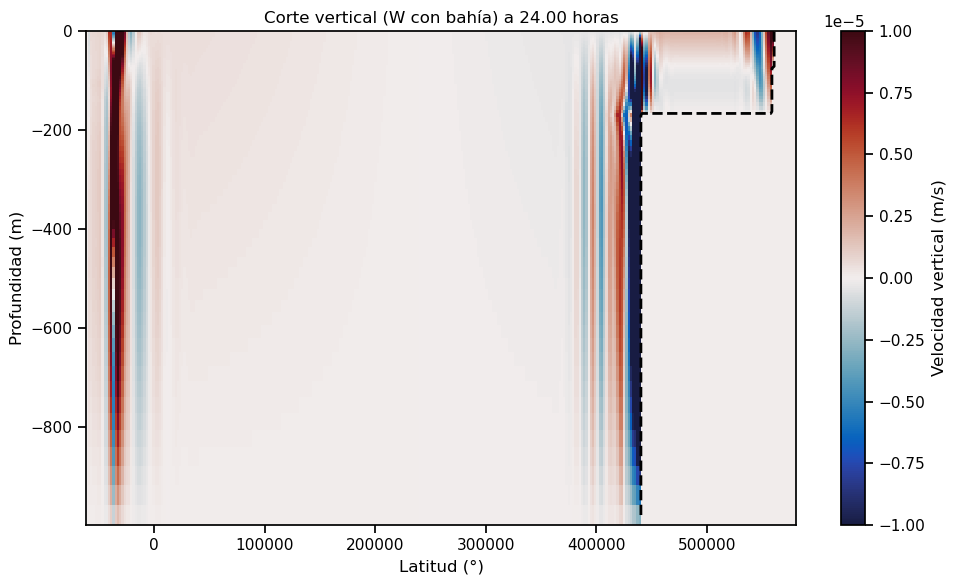

In [23]:
animar_perfil_w(
    nc_bay,
    nc_nobay,
    gr_bay,
    time,
    subtract=False,
    outname="animationWperfil_sponge.mp4",
    vmin=-1e-5,
    vmax=1e-5,
    fps=2
)

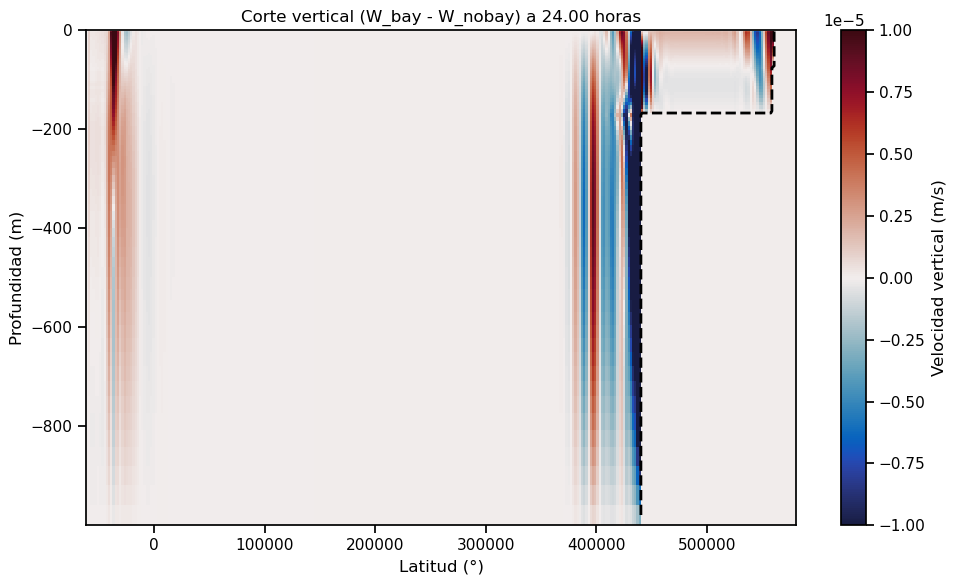

In [24]:
animar_perfil_w(
    nc_bay,
    nc_nobay,
    gr_bay,
    time,
    subtract=True,
    outname="animationWperfil_diff.mp4",
    vmin=-1e-5,
    vmax=1e-5,
    fps=2
)

In [8]:
### VIDEOS COMPARACIÓN ETHA

from moviepy import VideoFileClip, clips_array

# Rutas de los videos
video1_path = 'animationWperfil_diff_sponge.mp4'
video2_path = 'animationWperfil_diff.mp4'
#video2_path = 'animationEtha_diff.mp4'

# Cargar los videos
clip1 = VideoFileClip(video1_path)
clip2 = VideoFileClip(video2_path)

combined = clips_array([[clip1, clip2]])
combined.preview()

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1000, 600], 'bitrate': 19, 'fps': 2.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.19.100 libx264'}}], 'input_number': 0}], 'duration': 68.0, 'bitrate': 20, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [1000, 600], 'video_bitrate': 19, 'video_fps': 2.0, 'video_duration': 68.0, 'video_n_frames': 136}
/opt/anaconda3/lib/python3.12/site-packages/imageio_ffmpeg/binaries/ffmpeg-macos-aarch64-v7.1 -i animationWperfil_diff_sponge.mp4 -loglevel error -f image2pipe -vf scale=1000:600 -s

In [10]:
print(gr_bay.variables.keys())

dict_keys(['Z', 'RC', 'Zp1', 'RF', 'Zu', 'RU', 'Zl', 'RL', 'drC', 'drF', 'X', 'Y', 'XC', 'YC', 'Xp1', 'Yp1', 'XG', 'YG', 'dxC', 'dyC', 'dxF', 'dyF', 'dxG', 'dyG', 'dxV', 'dyU', 'rA', 'rAw', 'rAs', 'rAz', 'fCori', 'fCoriG', 'R_low', 'Ro_surf', 'Depth', 'HFacC', 'HFacW', 'HFacS'])


In [8]:
Z=gr_bay.variables['Z'][:]
RC=gr_bay.variables['RC'][:]
YC = gr_bay.variables['YC'][:, 0]

In [10]:
print(Z.shape)
print(RC.shape)
print(RC-Z)
print(RC)


(50,)
(50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[-5.0000e-01 -1.5500e+00 -2.7000e+00 -3.9500e+00 -5.3000e+00 -6.7500e+00
 -8.3000e+00 -9.9500e+00 -1.1750e+01 -1.3700e+01 -1.5800e+01 -1.8100e+01
 -2.0600e+01 -2.3300e+01 -2.6200e+01 -2.9300e+01 -3.2650e+01 -3.6300e+01
 -4.0250e+01 -4.4500e+01 -4.9100e+01 -5.4100e+01 -5.9500e+01 -6.5300e+01
 -7.1550e+01 -7.8350e+01 -8.5700e+01 -9.3600e+01 -1.0215e+02 -1.1140e+02
 -1.2140e+02 -1.3225e+02 -1.4400e+02 -1.5670e+02 -1.7045e+02 -1.8530e+02
 -2.0135e+02 -2.1870e+02 -2.3745e+02 -2.5775e+02 -2.7970e+02 -3.0340e+02
 -3.2900e+02 -3.5670e+02 -3.8665e+02 -4.1905e+02 -4.5410e+02 -4.9195e+02
 -5.3285e+02 -5.7700e+02]


In [13]:
np.cumsum(np.diff(Z))

array([  -1.05,   -2.2 ,   -3.45,   -4.8 ,   -6.25,   -7.8 ,   -9.45,
        -11.25,  -13.2 ,  -15.3 ,  -17.6 ,  -20.1 ,  -22.8 ,  -25.7 ,
        -28.8 ,  -32.15,  -35.8 ,  -39.75,  -44.  ,  -48.6 ,  -53.6 ,
        -59.  ,  -64.8 ,  -71.05,  -77.85,  -85.2 ,  -93.1 , -101.65,
       -110.9 , -120.9 , -131.75, -143.5 , -156.2 , -169.95, -184.8 ,
       -200.85, -218.2 , -236.95, -257.25, -279.2 , -302.9 , -328.5 ,
       -356.2 , -386.15, -418.55, -453.6 , -491.45, -532.35, -576.5 ])

In [25]:
np.min(Z)
np.min(YC)

-672900.0

In [ ]:
RC_filtered = RC[RC > -250]
YC_filtered = YC[YC > -3000]
Idx_Z=len(RC_filtered)-1
print(RC_filtered)
print(RC[Idx_Z])
print(YC[-1])
print(YC_filtered)

[  -0.5    -1.55   -2.7    -3.95   -5.3    -6.75   -8.3    -9.95  -11.75
  -13.7   -15.8   -18.1   -20.6   -23.3   -26.2   -29.3   -32.65  -36.3
  -40.25  -44.5   -49.1   -54.1   -59.5   -65.3   -71.55  -78.35  -85.7
  -93.6  -102.15 -111.4  -121.4  -132.25 -144.   -156.7  -170.45 -185.3
 -201.35 -218.7  -237.45]
-237.45
-168813.88888888698
[]


In [35]:
def animar_perfil_w_zoombay(
    nc_bay,
    nc_nobay,
    gr,
    time,
    subtract=False,
    outname="animationWperfil_diff.mp4",
    vmin=-1e-5,
    vmax=1e-5,
    fps=2,
    # Parámetros para el zoom
    RC_cut=-250,      # Limite de profundidad en m a recortar
    YC_cut=420,      # Limite de puntos a recortar desde la parte inferior del dominio
):
    """
    Crea y guarda una animación del perfil vertical de la velocidad W
    a lo largo de un corte en X=EjeXBay. Puede usar la diferencia
    (con bahía - sin bahía) o solamente la simulación con bahía.

    Parámetros
    ----------
    nc_bay : netCDF con la simulación "con bahía".
    nc_nobay : netCDF con la simulación "sin bahía".
    time : array-like
        Vector de tiempo (en segundos).
    mask3D : np.ndarray
        Máscara 3D (por ejemplo, HFacC) para contornear la topografía en la sección.
        Debe tener forma [nz, ny, nx].
    YC : np.ndarray
        Coordenadas Y (2D o 1D; para el corte vertical se asume [ny, 1] o [ny]).
    RC : np.ndarray
        Coordenadas verticales, típicamente con shape [nz].
    EjeXBay : int
        Índice de X donde se hará el corte vertical.
    subtract : bool
        Si True, grafica la diferencia W_bay - W_nobay.
        Si False, grafica solo W_bay.
    outname : str
        Nombre del archivo mp4 que se generará.
    vmin, vmax : float
        Límite mínimo y máximo para la escala de colores.
    fps : int
        Frames por segundo para la animación.

    Ejemplo:
        animar_perfil_w(nc, nc2, time, mask3D, YC, RC, EjeXBay=136,
                        subtract=True, outname="animationWperfil_diff1.mp4")
    """
    # Coordenadas
    XC = gr.variables['XC'][0, :]
    YC = gr.variables['YC'][:, 0]
    RC = gr.variables['RC'][:]
    hFacC = gr.variables['HFacC'][:]
    mask3D = np.ma.getmask(np.ma.masked_values(hFacC[:,:], 0))
    EjeXBay= (len(XC)//2)-1 # Centro del dominio en X

    # Crear slices para hacer zoom
    # RC: [ : RC_cut] => las primeras RC_cut filas
    # Y: [-Y_cut : ] => las últimas Y_cut filas
    RC_filtered = RC[RC > RC_cut]
    Idx_Z=len(RC_filtered)-1
    rc_slice = slice(None, Idx_Z)
    y_slice = slice(-YC_cut, None)

    #Recortar también las coordenadas y la máscara
    Y_zoom = YC[y_slice]
    RC_zoom = RC[rc_slice]
    mask_zoom = mask3D[rc_slice, y_slice]

    # 1) Crear la figura y ejes
    fig, ax = plt.subplots(figsize=(10, 6))

    # 2) Frame inicial (time=0) para dimensionar correctamente el pcolormesh
    W1_init = nc_bay.variables['W'][0, rc_slice, y_slice, EjeXBay]  # [z, y]
    if subtract:
        W2_init = nc_nobay.variables['W'][0, rc_slice, y_slice, EjeXBay]
        W_init = W1_init - W2_init
        title_base = "Corte vertical (W_bay - W_nobay)"
    else:
        W_init = W1_init
        title_base = "Corte vertical (W con bahía)"

    # 3) Crear pcolormesh inicial
    mesh = ax.pcolormesh(
        Y_zoom,  # Eje horizontal (latitud) - asumiendo YC tiene shape [ny, 1]
        RC_zoom,        # Eje vertical (profundidad)
        W_init,
        vmin=vmin,
        vmax=vmax,
        cmap=cmo.cm.balance
    )

    # 4) Añadir contorno para la topografía (mask3D=0 => tierra)
    ax.contour(
        Y_zoom,
        RC_zoom,
        mask_zoom[:, :, EjeXBay],  # shape [nz, ny]
        colors='black',
        linewidths=2,
        linestyles='--'
    )



    # Barra de color
    fig.colorbar(mesh, ax=ax, label='Velocidad vertical (m/s)')

    # Título inicial
    ax.set_title(f"{title_base} a {time[0]/3600:.2f} horas")

    # Ejes
    ax.set_xlabel("Latitud (°)")
    ax.set_ylabel("Profundidad (m)")

    # Ajustes de layout
    plt.tight_layout()

    # 5) Función de actualización
    def update(frame):
        W1 = nc_bay.variables['W'][frame, rc_slice, y_slice, EjeXBay] # [z, y]
        if subtract:
            W2 = nc_nobay.variables['W'][frame, rc_slice, y_slice, EjeXBay] # [z, y]
            W_frame = W1 - W2
            ax.set_title(f"{title_base} a {time[frame] / 3600:.2f} horas")
        else:
            W_frame = W1
            ax.set_title(f"{title_base} a {time[frame] / 3600:.2f} horas")

        # Actualizar el pcolormesh
        mesh.set_array(W_frame.ravel())
        return mesh,

    # 6) Crear la animación
    anim = FuncAnimation(
        fig,
        update,
        frames=range(len(time)),
        blit=True
    )

    # 7) Guardar la animación en un archivo mp4
    anim.save(outname, fps=fps, writer="ffmpeg")

    # 8) Mostrar la figura final
    plt.show()

    return anim

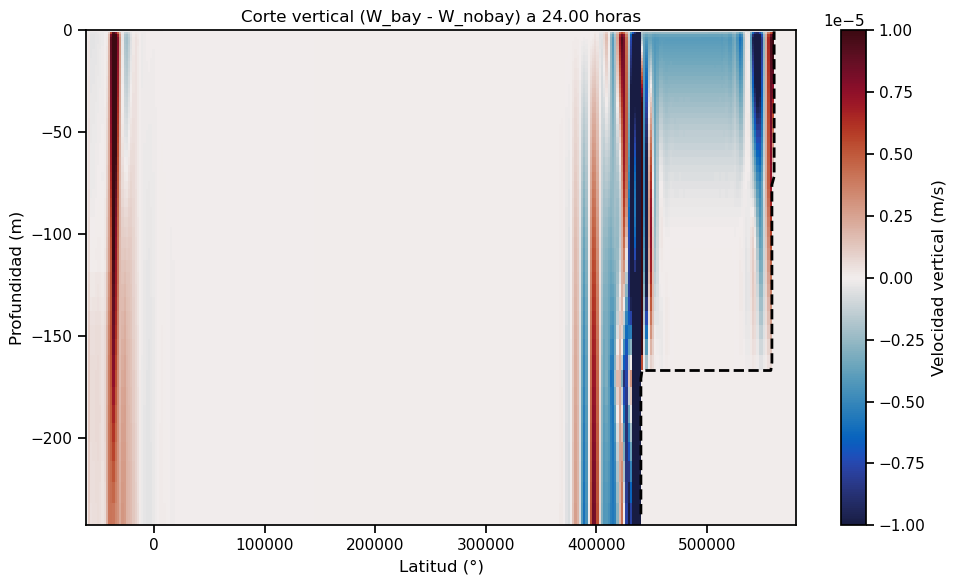

In [36]:
animar_perfil_w_zoombay(
    nc_bay,
    nc_nobay,
    gr_bay,
    time,
    subtract=True,
    outname="animationWperfil_diff_zoom_2p5hr.mp4",
    vmin=-1e-5,
    vmax=1e-5,
    fps=2,
    # Parámetros para el zoom
    RC_cut=-250,      # Limite de profundidad en m a recortar
    YC_cut=420,      # Limite de puntos a recortar desde la parte inferior del dominio
)

## Evaluacion de estación dentro de la bahía

In [25]:
def plot_bathymetry_full_zoom_with_station(gr, X_sym=150, Y_cut=420, 
                                           i_st=179, j_st=466):
    """
    Dibuja la batimetría (depth) en 2 subplots:
    1) Vista completa
    2) Zoom en la región de interés
    
    y superpone un marcador en (j_st, i_st).
    """
    # Extraer variables de gr
    depth = gr.variables['Depth'][:]
    mask = np.ma.getmask(np.ma.masked_values(depth, 0))  # mascara donde depth=0
    XC = gr.variables['XC'][:]
    YC = gr.variables['YC'][:]

    # Definir límites para la escala de color
    vmin = np.nanmin(-depth)
    vmax = np.nanmax(-depth)

    # Figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Subplot 1 (vista completa)
    pc1 = ax1.contourf(
        XC[0, :],
        YC[:, 0],
        np.ma.masked_array(-depth, mask=mask),
        cmap=cmo.cm.deep_r,
        vmin=vmin, vmax=vmax
    )
    ax1.set_aspect('equal')
    ax1.set_facecolor('tan')
    ax1.set_title('Bathymetry (vista completa)')
    
    # Marcar la estación también en la vista completa (opcional)
    x_sta = XC[j_st, i_st]
    y_sta = YC[j_st, i_st]
    ax1.plot(x_sta, y_sta, 'ro', markersize=6, label='Estación')
    ax1.legend()

    # Subplot 2 (zoom)
    X_axis_idx = len(XC[0, :]) // 2  # Centro aproximado en X
    pc2 = ax2.contourf(
        XC[0, X_axis_idx - X_sym : X_axis_idx + X_sym],
        YC[-Y_cut:, 0],
        np.ma.masked_array(
            -depth[-Y_cut:, X_axis_idx - X_sym : X_axis_idx + X_sym],
            mask=mask[-Y_cut:, X_axis_idx - X_sym : X_axis_idx + X_sym]
        ),
        cmap=cmo.cm.deep_r,
        vmin=vmin, vmax=vmax
    )
    ax2.set_aspect('equal')
    ax2.set_facecolor('tan')
    ax2.set_title('Bathymetry (zoom)')

    # Marcar la estación en el zoom (solo se verá si cae dentro de esos recortes)
    ax2.plot(x_sta, y_sta, 'ro', markersize=8)
    ax2.text(x_sta, y_sta, "Estación", color="white", fontsize=8,
             ha='left', va='bottom')

    # Barra de color global
    cbar = fig.colorbar(pc1, ax=[ax1, ax2], label='depth (m)')
    #plt.tight_layout()
    plt.show()


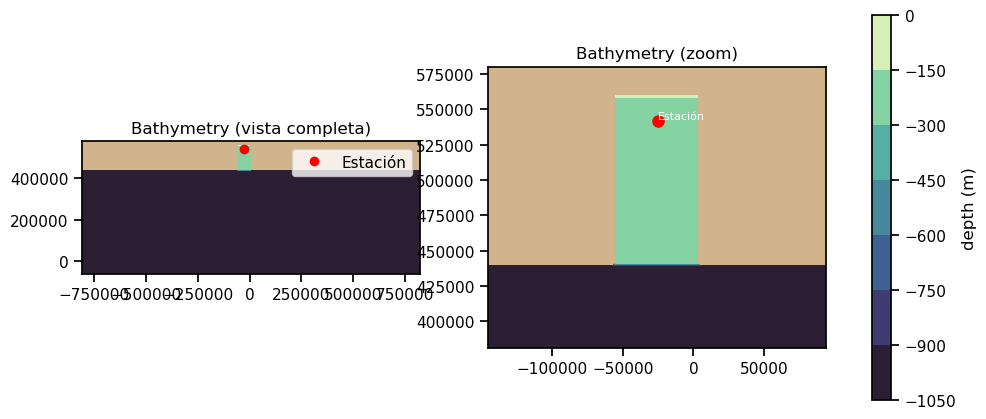

In [8]:
plot_bathymetry_full_zoom_with_station(gr_bay, X_sym=60, Y_cut=100, 
                                       i_st=136, j_st=300)

In [10]:
jstation, istation = 300, 136

In [29]:
eta_vals = nc_bay.variables['Eta'][:, jstation, istation]
tiempo = nc_bay.variables['T'][:]  # en segundos


KeyboardInterrupt: 

In [7]:
time27= time[time >= 27*3600]
print(time[373-337]/3600)

27.0


In [8]:
max_index =373-337
print("Index of maximum value:", max_index)
print("Time of maximum value (hours):", time[max_index] / 3600)


Index of maximum value: 36
Time of maximum value (hours): 27.0


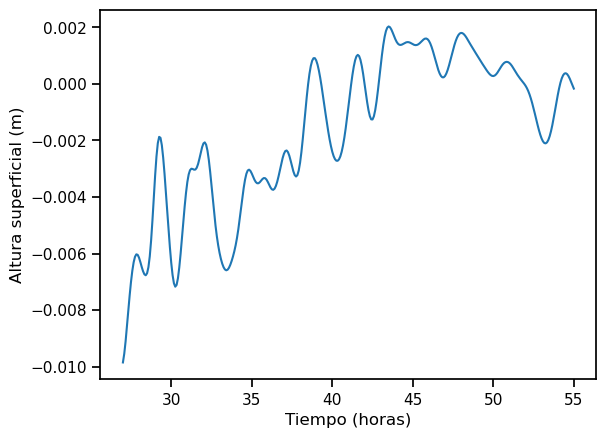

In [11]:
eta_vals_24_bay = nc_bay.variables['Eta'][36:, jstation, istation]
eta_vals_24_nobay = nc_nobay.variables['Eta'][36:, jstation, istation]
eta_diff_24 = eta_vals_24_bay - eta_vals_24_nobay
tiempo_24 = time[36:]


plt.plot(tiempo_24/3600, eta_diff_24)
plt.xlabel('Tiempo (horas)')
plt.ylabel('Altura superficial (m)')
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Asegúrate de que 'eta_vals' sea un array de floats:
eta = np.array(eta_diff_24, dtype=float)
# Y 'tiempo' también:
t = np.array(tiempo_24, dtype=float)

# Intervalo de muestreo (en segundos):
dt = t[1] - t[0]

# Frecuencia de muestreo (Hz = 1/seg)
fs = 1.0 / dt


In [13]:
#eta_demean = eta - np.mean(eta)            # quitar sólo la media
# o más completo:
eta_detrend = detrend(eta)                # quitar tendencia lineal

In [14]:
N = len(eta_detrend)  # número de puntos
Y = np.fft.rfft(eta_detrend)   # FFT unilateral (porque la serie es real)
freqs = np.fft.rfftfreq(N, d=dt)  # frecuencias asociadas

# Magnitud del espectro:
amplitud = np.abs(Y)

# Potencia espectral (densidad de potencia "simple"):
PSD = (1.0 / N**2) * np.abs(Y)**2  

# Si quieres la PSD con algo de normalización:
# en procesamiento de señales a veces se hace (2 / (fs*N)) * ...


In [15]:
freq_cph = freqs * 3600.0      # de Hz a ciclos/hora
freq_cpd = freqs * 86400.0     # de Hz a ciclos/día


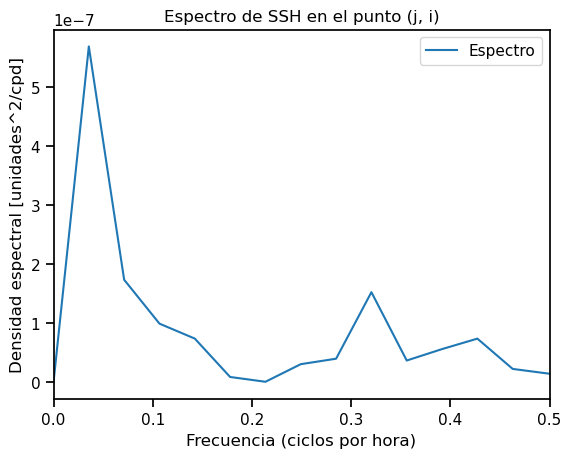

In [16]:
plt.figure()
plt.plot(freq_cph, PSD, label='Espectro')
plt.xlim(0, 0.5)  # ejemplo de rango de frecuencia
plt.xlabel('Frecuencia (ciclos por hora)')
plt.ylabel('Densidad espectral [unidades^2/cpd]')
plt.title('Espectro de SSH en el punto (j, i)')
plt.legend()
plt.show()


In [18]:
# Frecuencia analitica del seiche
# Formula de la frecuencia de seiche
# T_0=2.220[2L/(gh_1)^{1/2}]
# Dimensiones de la bahía
L = 119000  # Longitud de la bahía (m)
H = 164  # Profundidad en la boca (m)
g=9.81 # m/s^2
T_0 = 2.00 * (2*L / ((g*H)**0.5))
f_0 = 1 / T_0
print(f"Frecuencia de seiche: {f_0:.6f} ciclos por segundo")
print(f"Frecuencia de seiche: {f_0*3600:.6f} ciclos por hora")
print(f"Periodo de seihe {T_0/3600:.6f} horas")

Frecuencia de seiche: 0.000084 ciclos por segundo
Frecuencia de seiche: 0.303356 ciclos por hora
Periodo de seihe 3.296462 horas


### Segunda estación

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cmo

def plot_bathymetry_full_zoom_with_station(gr, i_st, j_st, radio=40):
    """
    Dibuja la batimetría (depth) en 2 subplots:
    1) Vista completa
    2) Zoom en la región de interés (radio celdas alrededor de (j_st, i_st))

    Parámetros
    ----------
    gr : objeto netCDF / MITgcmutils
        Contiene variables de la malla (XC, YC, Depth).
    i_st, j_st : int
        Índices (i, j) de la estación, en las dimensiones de la matriz.
    radio : int
        Número de celdas a recortar alrededor de (j_st, i_st) en ambas direcciones.
    """
    # Extraer variables de gr
    depth = gr.variables['Depth'][:]
    XC = gr.variables['XC'][:]
    YC = gr.variables['YC'][:]

    # Crear una máscara donde depth=0
    mask = np.ma.getmask(np.ma.masked_values(depth, 0))

    # Definir límites para la escala de color
    vmin = np.nanmin(-depth)
    vmax = np.nanmax(-depth)

    # Figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # ---------------- Subplot 1 (vista completa) ----------------
    pc1 = ax1.contourf(
        XC[0, :],
        YC[:, 0],
        np.ma.masked_array(-depth, mask=mask),
        cmap=cmo.cm.deep_r,
        vmin=vmin, vmax=vmax
    )
    ax1.set_aspect('equal')
    ax1.set_facecolor('tan')
    ax1.set_title('Bathymetry (vista completa)')

    # Coordenadas (x, y) de la estación para el scatter
    x_sta = XC[j_st, i_st]
    y_sta = YC[j_st, i_st]
    ax1.plot(x_sta, y_sta, 'ro', markersize=6, label='Estación')
    ax1.legend()

    # ---------------- Subplot 2 (zoom alrededor de la estación) ----------------
    # Aseguramos que los índices no se salgan de los límites
    ny, nx = depth.shape
    i_min = max(i_st - radio, 0)
    i_max = min(i_st + radio, nx)
    j_min = max(j_st - radio, 0)
    j_max = min(j_st + radio, ny)

    pc2 = ax2.contourf(
        XC[j_min:j_max, i_min:i_max],
        YC[j_min:j_max, i_min:i_max],
        np.ma.masked_array(-depth[j_min:j_max, i_min:i_max],
                           mask=mask[j_min:j_max, i_min:i_max]),
        cmap=cmo.cm.deep_r,
        vmin=vmin, vmax=vmax
    )
    ax2.set_aspect('equal')
    ax2.set_facecolor('tan')
    ax2.set_title(f'Bathymetry (zoom en {radio} celdas)')

    # Vuelve a dibujar la estación dentro del zoom, si cae en el recorte
    if j_min <= j_st < j_max and i_min <= i_st < i_max:
        ax2.plot(x_sta, y_sta, 'ro', markersize=8)
        ax2.text(x_sta, y_sta, "Estación", color="white", fontsize=8,
                 ha='left', va='bottom')

    # Barra de color global
    cbar = fig.colorbar(pc1, ax=[ax1, ax2], label='depth (m)')
    #plt.tight_layout()
    plt.show()


# -----------------------------#
# Ejemplo de uso:
# plot_bathymetry_full_zoom_with_station(gr,
#                                        i_st=179,
#                                        j_st=466,
#                                        radio=40)


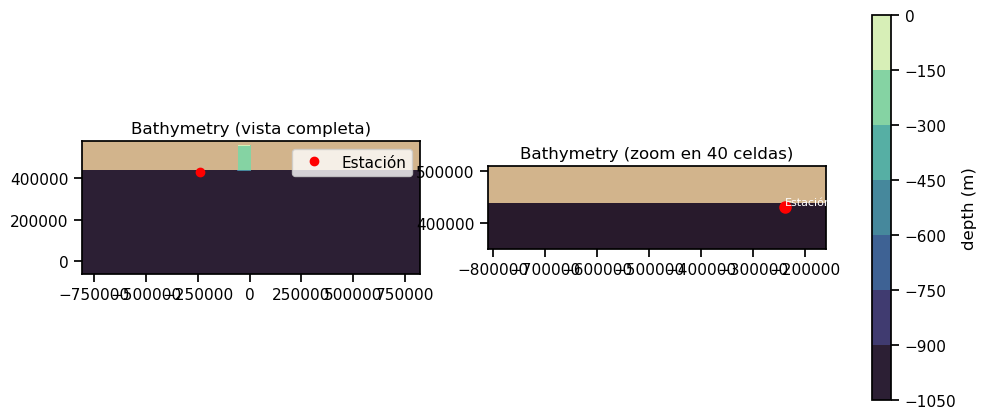

In [11]:
i_st_b, j_st_b = 30, 245
#i_st_b, j_st_b = 75, 248
plot_bathymetry_full_zoom_with_station(gr_bay, i_st_b, j_st_b, radio=40)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

def analizar_ssh_y_espectro(nc_bay, nc_nobay, time, jstation, istation):
    """
    Calcula la diferencia de altura superficial (Eta) entre
    configuraciones 'con bahía' y 'sin bahía' en el punto (jstation, istation),
    la grafica contra el tiempo, y luego muestra el espectro de frecuencias
    (calculado con FFT) de dicha señal.

    Parámetros
    ----------
    nc_bay : objeto netCDF (MITgcmutils)
        Contiene la variable 'Eta' para el caso con bahía.
    nc_nobay : objeto netCDF (MITgcmutils)
        Contiene la variable 'Eta' para el caso sin bahía.
    time : array-like
        Vector de tiempo, en segundos.
    jstation, istation : int
        Índices (j, i) de la grilla donde se extrae la serie de tiempo.
    """

    # 1) Extraer valores de 'Eta' (superficie) en la estación dada
    eta_vals_bay = nc_bay.variables['Eta'][:, jstation, istation]
    eta_vals_nobay = nc_nobay.variables['Eta'][:, jstation, istation]

    # 2) Diferencia de altura superficial
    eta_diff = eta_vals_bay - eta_vals_nobay
    t = np.array(time, dtype=float)

    # 3) Graficar la señal de diferencia vs. tiempo (en horas)
    plt.figure(figsize=(6, 4))
    plt.plot(t / 3600.0, eta_diff, label='Eta(bahía) - Eta(sin bahía)')
    plt.xlabel('Tiempo (horas)')
    plt.ylabel('Altura superficial (m)')
    plt.title(f'Diferencia de Eta en (j={jstation}, i={istation})')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 4) Procesar la señal para la FFT
    #    4.1) Asegurar que sea float y remover tendencia
    eta = np.array(eta_diff, dtype=float)
    eta_detrend = detrend(eta)

    #    4.2) Calcular la frecuencia de muestreo
    dt = t[1] - t[0]   # intervalo de muestreo (s)
    fs = 1.0 / dt      # frecuencia de muestreo (Hz)

    #    4.3) FFT unidireccional (porque es una señal real)
    N = len(eta_detrend)
    Y = np.fft.rfft(eta_detrend)           # FFT unilateral
    freqs = np.fft.rfftfreq(N, d=dt)       # vector de frecuencias

    #    4.4) Potencia espectral (forma simple)
    PSD = (1.0 / N**2) * np.abs(Y)**2

    #    4.5) Convertir frecuencias a ciclos/hora (cph) o ciclos/día (cpd)
    freq_cph = freqs * 3600.0

    # 5) Graficar espectro
    plt.figure(figsize=(6, 4))
    plt.plot(freq_cph, PSD, label='Espectro (PSD)')
    plt.xlim(0, 0.8)  # ejemplo de rango en cph
    plt.xlabel('Frecuencia (ciclos/hora)')
    plt.ylabel('Densidad espectral [m^2/cph] (aprox)')
    plt.title(f'Espectro de la diferencia de Eta (j={jstation}, i={istation})')
    plt.grid(True)
    plt.legend()
    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

def analizar_ssh_y_espectro_multistation(
    nc_bay, 
    nc_nobay, 
    time, 
    station_list,
    tmin_horas=27.0
):
    """
    Calcula y grafica la diferencia de altura superficial (Eta)
    entre configuraciones 'con bahía' y 'sin bahía' en varias estaciones,
    sobre la misma figura para la serie temporal y otra para la FFT.

    Parámetros
    ----------
    nc_bay : objeto netCDF (MITgcmutils)
        Contiene la variable 'Eta' para el caso con bahía.
    nc_nobay : objeto netCDF (MITgcmutils)
        Contiene la variable 'Eta' para el caso sin bahía.
    time : array-like
        Vector de tiempo, en segundos.
    station_list : list of tuples
        Lista de estaciones, cada una dada como (j_st, i_st).
        Ejemplo: [(300, 136), (305, 142)]
    tmin_horas : float
        Tiempo mínimo (en horas) a partir del cual se recorta la señal.
    """

    # --- Convertimos el vector de tiempo a numpy y calculamos índice de corte ---
    t = np.array(time, dtype=float)
    tmin_seg = tmin_horas * 3600.0
    # Índice donde comienza t >= tmin_seg
    idx_start = np.where(t >= tmin_seg)[0][0] if np.any(t >= tmin_seg) else 0

    # Recortamos el tiempo y convertimos a horas para graficar
    t_cut = t[idx_start:]
    t_cut_horas = t_cut / 3600.0

    # Figura 1: Serie temporal
    plt.figure(figsize=(7, 5))

    # Preparamos colores para cada estación (opcional)
    colors = plt.cm.tab10(np.linspace(0, 1, len(station_list)))

    # Diccionarios para almacenar los resultados de la FFT para graficar luego
    espectros = {}
    frec_cphs = None  # lo definiremos una sola vez (suponiendo que todas tienen mismo dt)

    for (j_st, i_st), color in zip(station_list, colors):
        # 1) Extraer valores de 'Eta' (superficie) en la estación dada (toda la serie)
        eta_vals_bay   = nc_bay.variables['Eta'][:, j_st, i_st]
        eta_vals_nobay = nc_nobay.variables['Eta'][:, j_st, i_st]

        # 2) Convertir a numpy y recortar
        eta_b = np.array(eta_vals_bay, dtype=float)
        eta_n = np.array(eta_vals_nobay, dtype=float)
        eta_b_cut = eta_b[idx_start:]
        eta_n_cut = eta_n[idx_start:]

        # 3) Diferencia de altura superficial
        eta_diff_cut = eta_b_cut - eta_n_cut

        # 4) Graficar la señal de diferencia vs. tiempo (en horas)
        label_str = f'Est. (j={j_st}, i={i_st})'
        plt.plot(t_cut_horas, eta_diff_cut, label=label_str, color=color)

        # 5) Procesar la señal para la FFT
        # 5.1) Quitar tendencia
        eta_detrend = detrend(eta_diff_cut)

        # 5.2) Frecuencia de muestreo (asumimos uniformidad temporal)
        dt = t_cut[1] - t_cut[0] if len(t_cut) > 1 else 1.0
        fs = 1.0 / dt

        # 5.3) FFT unidireccional
        N = len(eta_detrend)
        Y = np.fft.rfft(eta_detrend)
        freqs = np.fft.rfftfreq(N, d=dt)
            

        # 5.4) PSD (simple)
        PSD = (1.0 / N**2) * np.abs(Y)**2

        # 5.5) Frecuencia en ciclos/hora
        freq_cph = freqs * 3600.0

        # Almacenamos para graficar luego
        espectros[(j_st, i_st)] = (freq_cph, PSD)

        # Guardamos las frecuencias si no están definidas aún
        if frec_cphs is None:
            frec_cphs = freq_cph

    # --- Terminamos la figura de la serie temporal ---
    plt.xlabel('Tiempo (horas) desde ' + str(tmin_horas))
    plt.ylabel('Altura superficial (m)')
    plt.title(f'Diferencia Eta (bahía - sin bahía)\nDesde {tmin_horas} h')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Figura 2: Gráfico de espectros en la misma figura
    plt.figure(figsize=(7, 5))

    for ((j_st, i_st), color) in zip(station_list, colors):
        freq_cph, PSD = espectros[(j_st, i_st)]
        label_str = f'Est. (j={j_st}, i={i_st})'
        plt.plot(freq_cph, PSD, label=label_str, color=color)

    plt.xlim(0, 0.8)  # ejemplo de rango
    plt.xlabel('Frecuencia (ciclos/hora)')
    plt.ylabel('Densidad espectral [m^2/cph] (aprox)')
    plt.title(f'Espectro de diferencia de Eta\n(Varias estaciones, desde {tmin_horas} h)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


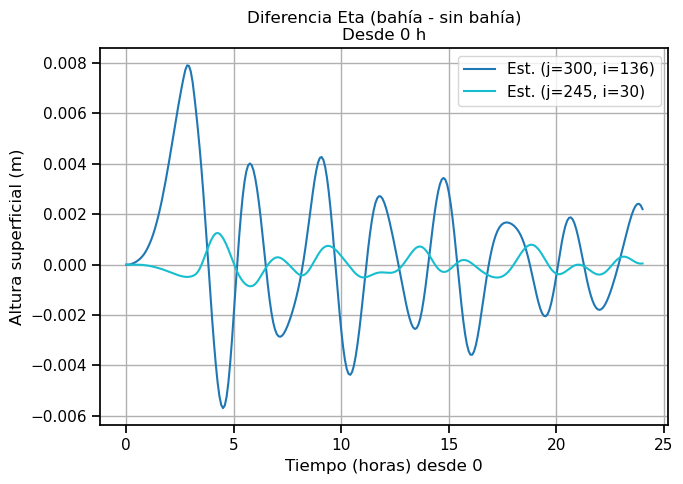

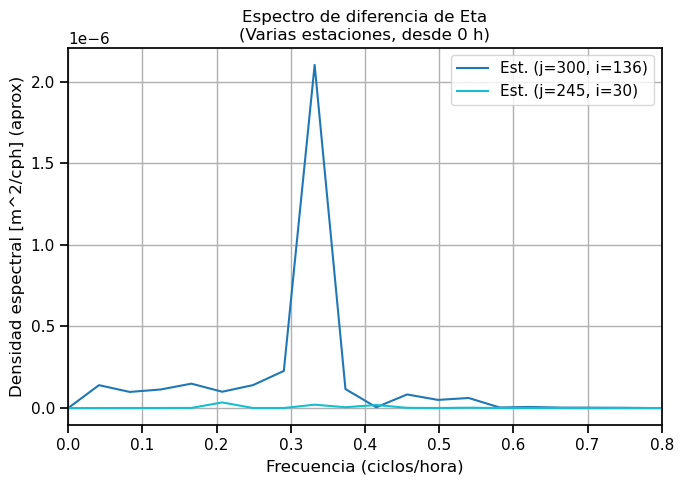

In [7]:
# Estaciones:
jstationA, istationA = 300, 136
jstationB, istationB = 245, 30

station_list = [
    (jstationA, istationA),
    (jstationB, istationB),
]

analizar_ssh_y_espectro_multistation(
    nc_bay,
    nc_nobay,
    time,
    station_list,
    tmin_horas=0
)

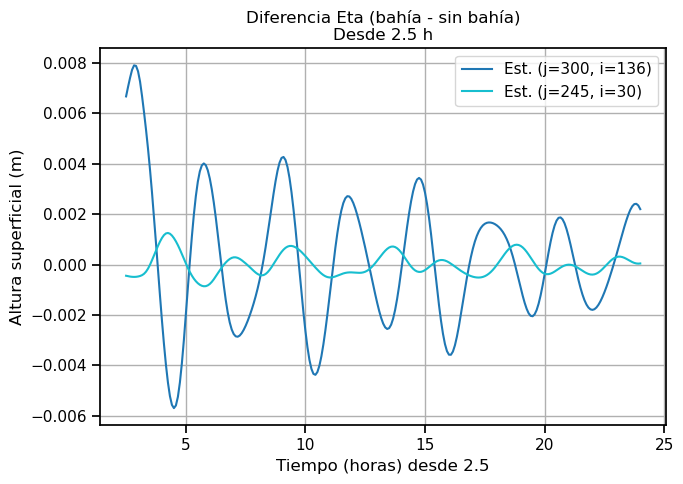

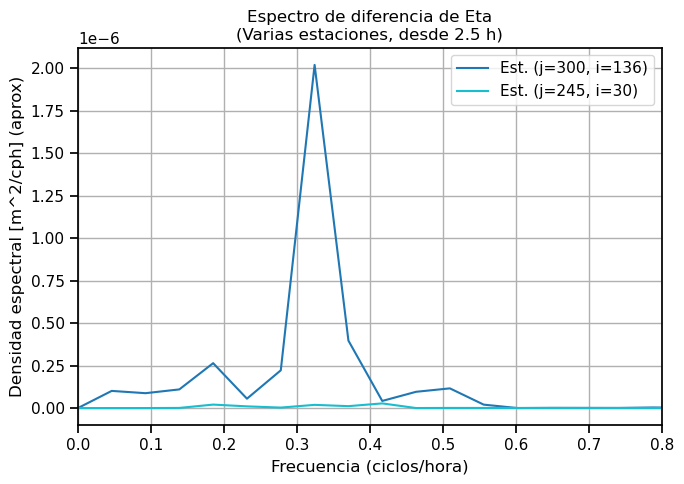

In [8]:
analizar_ssh_y_espectro_multistation(
    nc_bay,
    nc_nobay,
    time,
    station_list,
    tmin_horas=2.5
)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cmo

def plot_bathymetry_profile_by_j(gr, i=136, j_station=400):
    """
    Genera un perfil de la bahía a lo largo del eje j (filas),
    manteniendo fijo el índice i (columna).
    
    El eje X del gráfico se basa en la coordenada Y (YC[:, i]).
    Sin embargo, la ubicación de la estación se especifica con el índice
    j_station, y la función automáticamente dibuja la línea vertical
    en la coordenada Y correspondiente a YC[j_station, i].
    
    Parámetros
    ----------
    gr : objeto netCDF / MITgcmutils
        Contiene variables 'Depth', 'XC', 'YC' de la malla.
    i : int
        Índice de columna (i) donde se hace el corte a lo largo de j.
    j_station : int
        Índice de fila donde está la estación; se usará para trazar
        la línea vertical en el valor YC[j_station, i].
    """

    # Extraer variables
    depth = gr.variables['Depth'][:]  # shape ~ (ny, nx)
    XC = gr.variables['XC'][:]       # shape ~ (ny, nx)
    YC = gr.variables['YC'][:]       # shape ~ (ny, nx)

    # Perfil a lo largo de j, para la columna i
    Y_profile = YC[:, i]        # coordenada Y en cada fila
    Depth_profile = -depth[:, i] # profundidad (negativa para graficar hacia abajo)

    # Ubicación en Y de la estación, a partir de su índice j
    # (ojo que si j_station está fuera del rango [0, ny-1], habrá error)
    y_station = Y_profile[j_station]

    # Figura
    plt.figure(figsize=(8, 4))
    plt.plot(Y_profile, Depth_profile, label=f'Perfil en i={i}', color='blue')
    plt.xlabel('Coordenada Y')
    plt.ylabel('Profundidad (m)')
    plt.title(f'Perfil de la Bahía en i={i}')

    # Línea vertical en la ubicación de la estación
    plt.axvline(x=y_station, color='red', linestyle='--',
                label=f'Estación j={j_station}')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



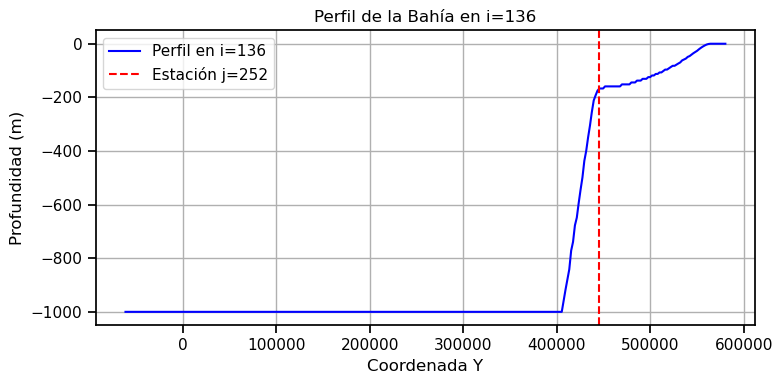

In [32]:
j_st_a = 252
i_st_a = 136
plot_bathymetry_profile_by_j(gr_bay, i=i_st_a, j_station=j_st_a)


In [23]:
print('Profundidad en la estación:', gr_bay.variables['Depth'][j_st, i_st])

Profundidad en la estación: 166.9


In [35]:
import numpy as np

def distance_between_stations(gr, j1, i1, j2, i2):
    """
    Calcula la distancia (en las mismas unidades que XC, YC) entre dos estaciones
    dadas por sus índices (j1, i1) y (j2, i2) en la malla de MITgcm.
    
    Parámetros
    ----------
    gr : objeto netCDF/MITgcmutils
        Contiene las variables 'XC' y 'YC'.
    j1, i1, j2, i2 : int
        Índices (j, i) de ambas estaciones.

    Retorna
    -------
    dist : float
        Distancia entre las dos estaciones, en las mismas unidades
        en que estén definidas XC y YC (habitualmente metros).
    """
    XC = gr.variables['XC'][:]
    YC = gr.variables['YC'][:]

    x1 = XC[j1, i1]
    y1 = YC[j1, i1]
    x2 = XC[j2, i2]
    y2 = YC[j2, i2]

    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

# Ejemplo de uso:
jstationA, istationA = 252, 136
jstationB, istationB = 252, 75

dist_m = distance_between_stations(gr_bay, jstationA, istationA, jstationB, istationB)
print(f"La distancia entre las estaciones A y B es ~{dist_m:.2f} m")

# Si necesitas la distancia en km:
dist_km = dist_m / 1000.0
print(f"Distancia entre A y B en km: ~{dist_km:.3f} km")


La distancia entre las estaciones A y B es ~122514.75 m
Distancia entre A y B en km: ~122.515 km


## Densidad

In [13]:
# Coordenadas
XC = gr_bay.variables['XC'][0, :]
YC = gr_bay.variables['YC'][:, 0]
RC = gr_bay.variables['RC'][:]
hFacC = gr_bay.variables['HFacC'][:]
mask3D = np.ma.getmask(np.ma.masked_values(hFacC[:, :, :], 0))
EjeXBay = len(XC)//2  # Centro del dominio en X

# Calcular densidad inicial
T_init = nc_bay.variables['Temp'][0, :, :, EjeXBay]
S_init = nc_bay.variables['S'][0, :, :, EjeXBay]
lon_ref = XC[EjeXBay]
lat_ref = YC

SA_init = gsw.SA_from_SP(S_init, -RC[:, None], lon_ref, lat_ref)
CT_init = gsw.CT_from_pt(SA_init, T_init)
sigma0_init = gsw.sigma0(SA_init, CT_init) + 1000

NameError: name 'gsw' is not defined

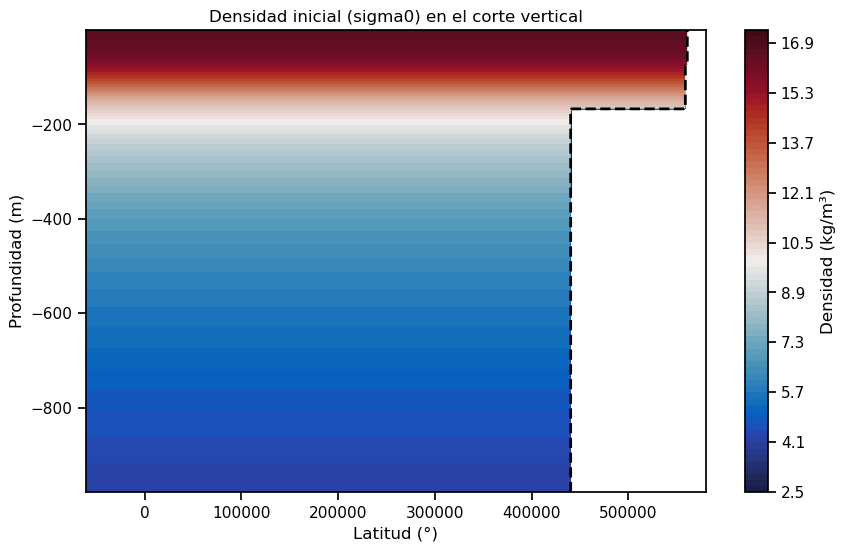

In [32]:
# Crear un gráfico de contorno de la densidad inicial
plt.figure(figsize=(10, 6))
plt.contourf(
    YC,
    RC,
    T_init,
    levels=np.arange(2.5, 17.5, 0.2),
    cmap=cmo.cm.balance
)
plt.colorbar(label='Densidad (kg/m³)')
plt.title('Densidad inicial (sigma0) en el corte vertical')
plt.xlabel('Latitud (°)')
plt.ylabel('Profundidad (m)')
plt.contour(
    YC,
    RC,
    mask3D[:, :, EjeXBay],
    colors='black',
    linewidths=2,
    linestyles='--'
)
plt.show()

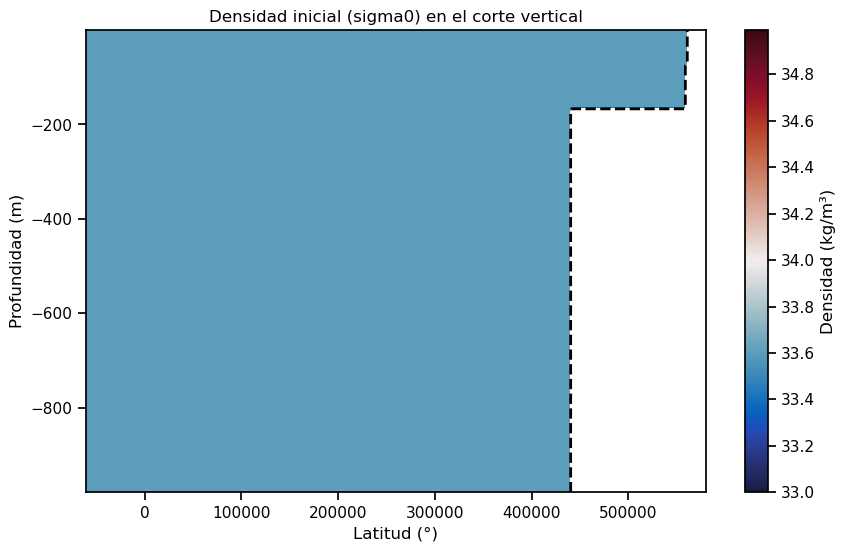

In [33]:
# Crear un gráfico de contorno de la densidad inicial
plt.figure(figsize=(10, 6))
plt.contourf(
    YC,
    RC,
    S_init,
    levels=np.arange(33, 35, 0.01),
    cmap=cmo.cm.balance
)
plt.colorbar(label='Densidad (kg/m³)')
plt.title('Densidad inicial (sigma0) en el corte vertical')
plt.xlabel('Latitud (°)')
plt.ylabel('Profundidad (m)')
plt.contour(
    YC,
    RC,
    mask3D[:, :, EjeXBay],
    colors='black',
    linewidths=2,
    linestyles='--'
)
plt.show()

In [10]:
def animar_perfil_w_isopicnas(
    nc_bay,
    nc_nobay,
    gr,
    time,
    subtract=False,
    outname="animationWperfil_diff_isopicnas.mp4",
    vmin=-1e-5,
    vmax=1e-5,
    fps=2,
    levels_isopicnas=np.arange(1024, 1028, 0.2)
):
    XC = gr.variables['XC'][0, :]
    YC = gr.variables['YC'][:, 0]
    RC = gr.variables['RC'][:]
    hFacC = gr.variables['HFacC'][:]
    mask3D = np.ma.getmask(np.ma.masked_values(hFacC[:, :, :], 0))
    EjeXBay = len(XC)//2

    rho0 = 999.8
    tAlpha = 2e-4
    sBeta = 7.4e-4
    tRef = np.array([16.6, 16.6, 16.6, 16.6, 16.6, 16.58, 16.53, 16.5, 16.5, 16.5, 
	16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 
	16.47, 16.42, 16.4, 16.4, 16.39, 16.34, 16.29, 16.2, 16.11, 16.03, 
	15.94, 15.85, 15.76, 15.64, 15.46, 15.28, 15.06, 14.84, 14.59, 14.32, 
	14.03, 13.73, 13.4, 13.01, 12.61, 12.22, 11.83, 11.5, 11.2, 10.91, 
	10.65, 10.38, 10.09, 9.78, 9.54, 9.33, 9.13, 8.96, 8.78, 8.62, 
	8.44, 8.27, 8.1, 7.91, 7.7, 7.48, 7.32, 7.14, 6.97, 6.8, 
	6.65, 6.52, 6.39, 6.26, 6.13, 6.01, 5.88, 5.75, 5.63, 5.49, 
	5.37, 5.24, 5.09, 4.92, 4.76, 4.63, 4.5, 4.38, 4.25, 4.11])  # reemplaza con tus valores del archivo data
    sRef = np.array([33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.65, 33.69, 33.7, 33.7, 
	33.7, 33.7, 33.71, 33.75, 33.8, 33.8, 33.8, 33.8, 33.8, 33.82, 
	33.86, 33.9, 33.9, 33.9, 33.93, 33.97, 34.0, 34.0, 34.0, 34.05, 
	34.09, 34.13, 34.18, 34.2, 34.2, 34.2, 34.2, 34.2, 34.2, 34.2, 
	34.22, 34.26, 34.3, 34.3, 34.3, 34.3, 34.3, 34.32, 34.36, 34.4, 
	34.4, 34.4, 34.4, 34.4, 34.4, 34.4, 34.4, 34.44, 34.48, 34.53,])  # reemplaza con tus valores del archivo data

    W_bay_init = nc_bay.variables['W'][0, :, :, EjeXBay]
    T_init = nc_bay.variables['T'][0, :, :, EjeXBay]
    S_init = nc_bay.variables['S'][0, :, :, EjeXBay]

    if subtract:
        W_nobay_init = nc_nobay.variables['W'][0, :, :, EjeXBay]
        W_init = W_bay_init - W_nobay_init
        title_base = "Corte vertical (W_bay - W_nobay) con isopicnas iniciales"
    else:
        W_init = W_bay_init
        title_base = "Corte vertical (W con bahía) con isopicnas iniciales"

    # Densidad inicial constante para toda la animación
    rho_init = rho0 * (1 - tAlpha*(T_init - tRef[:, None]) + sBeta*(S_init - sRef[:, None]))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Inicializa pcolormesh
    mesh = ax.pcolormesh(YC, RC, W_init, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.contour(YC, RC, mask3D[:, :, EjeXBay], colors='black', linewidths=2, linestyles='--')

    # Isopicnas iniciales constantes
    cs = ax.contour(YC, RC, rho_init, levels=levels_isopicnas, colors='k', linewidths=1)
    ax.clabel(cs, inline=True, fontsize=9, fmt='%.1f')

    fig.colorbar(mesh, ax=ax, label='Velocidad vertical (m/s)')
    ax.set_xlabel("Latitud (°)")
    ax.set_ylabel("Profundidad (m)")

    def update(frame):
        W_bay = nc_bay.variables['W'][frame, :, :, EjeXBay]
        if subtract:
            W_nobay = nc_nobay.variables['W'][frame, :, :, EjeXBay]
            W_frame = W_bay - W_nobay
        else:
            W_frame = W_bay

        mesh.set_array(W_frame.ravel())
        ax.set_title(f"{title_base} a {time[frame]/3600:.2f} horas")

        return mesh,

    anim = FuncAnimation(fig, update, frames=len(time), blit=False)
    anim.save(outname, fps=fps, writer="ffmpeg")
    plt.show()

    return anim

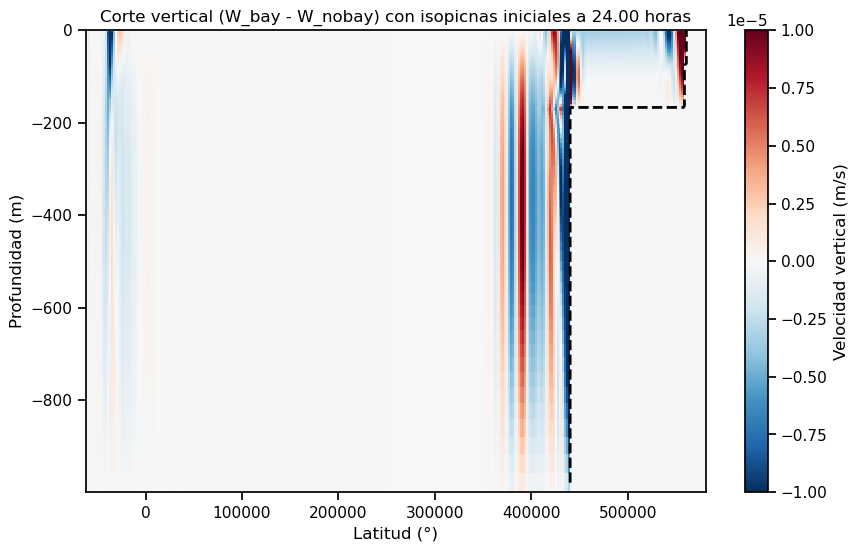

In [ ]:
animar_perfil_w_isopicnas(
    nc_bay,
    nc_nobay,
    gr_bay,
    time,
    subtract=True,
    outname="animationWperfil_diff_isopicnas1.mp4",
    vmin=-1e-5,
    vmax=1e-5,
    fps=2,
    levels_isopicnas=np.arange(1024, 1028, 0.2)
)

In [ ]:
XC = gr_bay.variables['XC'][0, :]
YC = gr_bay.variables['YC'][:, 0]
RC = gr_bay.variables['RC'][:]
hFacC = gr_bay.variables['HFacC'][:]
mask3D = np.ma.getmask(np.ma.masked_values(hFacC[:, :, :], 0))
EjeXBay = len(XC)//2

rho0 = 999.8
tAlpha = 2e-4
sBeta = 7.4e-4
tRef = np.array([16.6, 16.6, 16.6, 16.6, 16.6, 16.58, 16.53, 16.5, 16.5, 16.5, 
16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 
16.47, 16.42, 16.4, 16.4, 16.39, 16.34, 16.29, 16.2, 16.11, 16.03, 
15.94, 15.85, 15.76, 15.64, 15.46, 15.28, 15.06, 14.84, 14.59, 14.32, 
14.03, 13.73, 13.4, 13.01, 12.61, 12.22, 11.83, 11.5, 11.2, 10.91, 
10.65, 10.38, 10.09, 9.78, 9.54, 9.33, 9.13, 8.96, 8.78, 8.62, 
8.44, 8.27, 8.1, 7.91, 7.7, 7.48, 7.32, 7.14, 6.97, 6.8, 
6.65, 6.52, 6.39, 6.26, 6.13, 6.01, 5.88, 5.75, 5.63, 5.49, 
5.37, 5.24, 5.09, 4.92, 4.76, 4.63, 4.5, 4.38, 4.25, 4.11])  # reemplaza con tus valores del archivo data
sRef = np.array([33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 
	33.6,,])  # reemplaza con tus valores del archivo data

W_bay_init = nc_bay.variables['W'][0, :, :, EjeXBay]
T_init = nc_bay.variables['Temp'][0, :, :, EjeXBay]
S_init = nc_bay.variables['S'][0, :, :, EjeXBay]

In [15]:
# Densidad inicial constante para toda la animación
rho_init = rho0 * (1 - tAlpha*(T_init - tRef[:, None]) + sBeta*(S_init - sRef[:, None]))

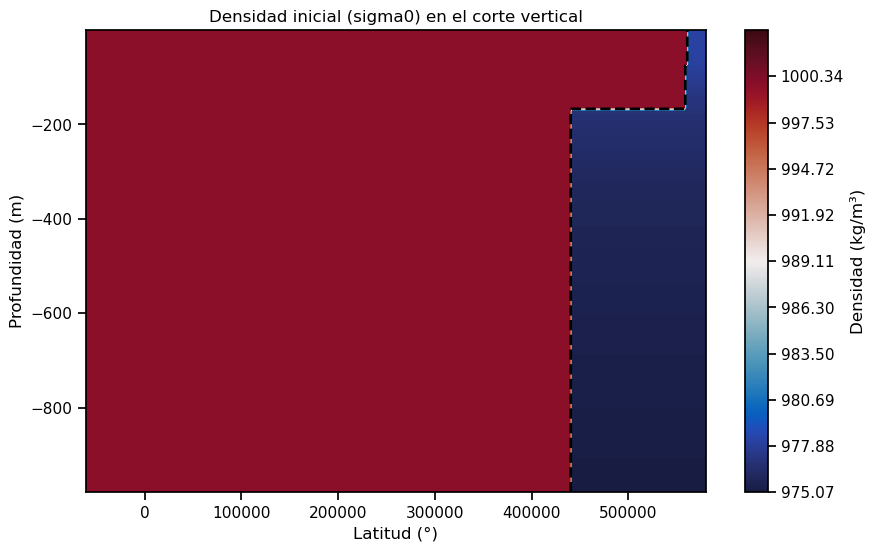

In [16]:
#graficar el perfil de densidad inicial
plt.figure(figsize=(10, 6))
plt.contourf(
    YC,
    RC,
    rho_init,
    levels= np.arange(975.07474604, 1003.14153156, 0.001,),
    cmap=cmo.cm.balance
)
plt.colorbar(label='Densidad (kg/m³)')
plt.title('Densidad inicial (sigma0) en el corte vertical') 
plt.xlabel('Latitud (°)')
plt.ylabel('Profundidad (m)')
plt.contour(
    YC,
    RC,
    mask3D[:, :, EjeXBay],
    colors='black',
    linewidths=2,
    linestyles='--'
)
plt.show()

In [18]:
print(np.min(rho_init))
print(np.max(rho_init))

975.07474604
1003.14153156


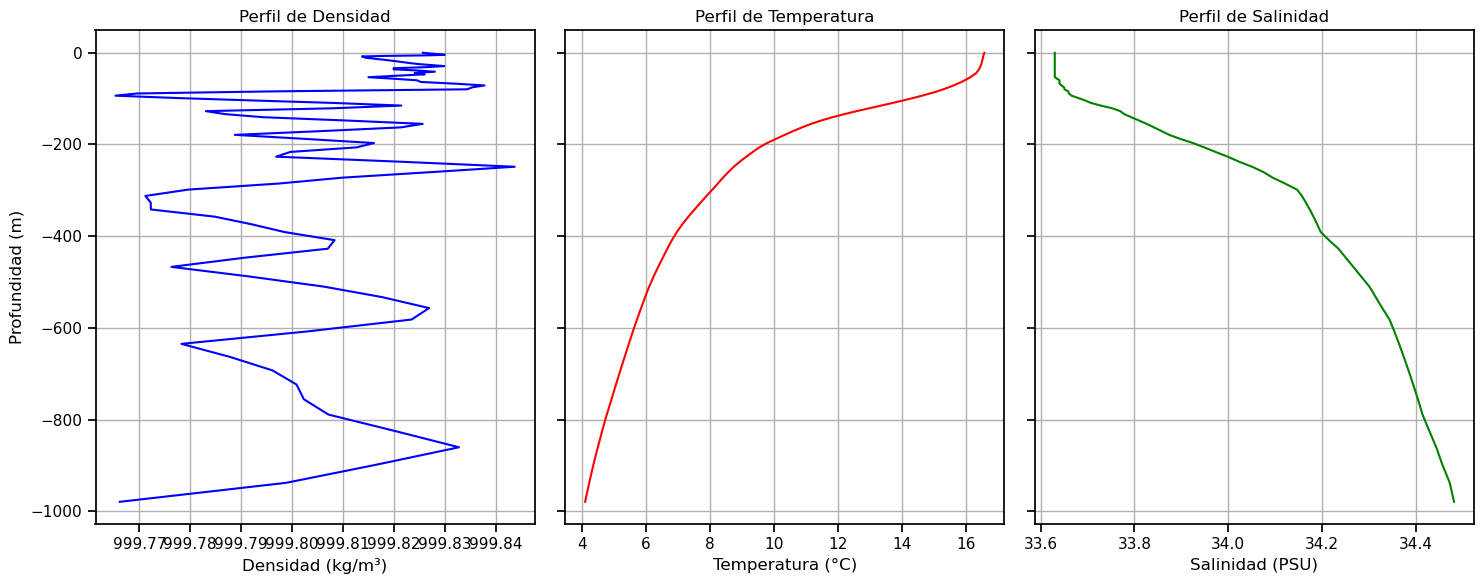

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Subplot 1: Density
axes[0].plot(rho_init[:, 2], RC, color='blue', label='Densidad')
axes[0].set_xlabel('Densidad (kg/m³)')
axes[0].set_ylabel('Profundidad (m)')
axes[0].set_title('Perfil de Densidad')
axes[0].grid()

# Subplot 2: Temperature
axes[1].plot(T_init[:, 2], RC, color='red', label='Temperatura')
axes[1].set_xlabel('Temperatura (°C)')
axes[1].set_title('Perfil de Temperatura')
axes[1].grid()

# Subplot 3: Salinity
axes[2].plot(S_init[:, 2], RC, color='green', label='Salinidad')
axes[2].set_xlabel('Salinidad (PSU)')
axes[2].set_title('Perfil de Salinidad')
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Supón que:
# - rho_profile es tu perfil de densidad rho_init[:, 2]
# - RC es tu vector de profundidad (debe tener el mismo largo que rho_profile)

rho_profile = rho_init[:, 2]
z = RC  # normalmente negativo, por convención oceánica

# Calculamos derivada vertical de la densidad
drho_dz = np.gradient(rho_profile, z)

# Buscamos el índice donde el gradiente es máximo en magnitud
picnoclina_idx = np.argmax(np.abs(drho_dz))
z_picnoclina = z[picnoclina_idx]
rho_picnoclina = rho_profile[picnoclina_idx]

# Visualización
plt.figure(figsize=(5, 6))
plt.plot(rho_profile, z, label='Densidad')
plt.axhline(z_picnoclina, color='r', linestyle='--', label='Picnoclina')
#plt.gca().invert_yaxis()
plt.xlabel('Densidad (kg/m³)')
plt.ylabel('Profundidad (m)')
plt.legend()
plt.title('Perfil de Densidad y Picnoclina')
plt.grid()
plt.show()


NameError: name 'rho_init' is not defined

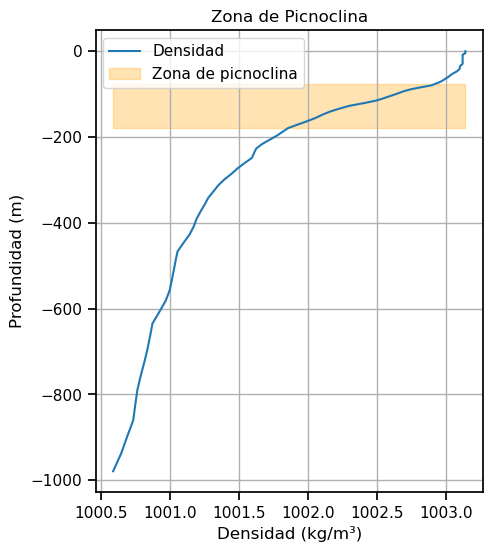

Picnoclina entre -75.80 m y -179.35 m


In [41]:
# Densidad y profundidad
rho_profile = rho_init[:, 2]
z = RC  # ojo, en MITgcm normalmente es negativo

# Gradiente vertical de densidad
drho_dz = np.gradient(rho_profile, z)

# Umbral: 50% del valor máximo de |drho_dz|
threshold = 0.40 * np.max(np.abs(drho_dz))

# Índices donde el gradiente supera el umbral
picnoclina_mask = np.abs(drho_dz) > threshold

# Encontrar rango de profundidades
if np.any(picnoclina_mask):
    indices = np.where(picnoclina_mask)[0]
    z_start = z[indices[0]]
    z_end = z[indices[-1]]
else:
    z_start = z_end = np.nan  # No hay picnoclina detectable

# Plot
plt.figure(figsize=(5, 6))
plt.plot(rho_profile, z, label='Densidad')
plt.fill_betweenx(z, np.min(rho_profile), np.max(rho_profile), 
                  where=picnoclina_mask, color='orange', alpha=0.3, label='Zona de picnoclina')
plt.xlabel('Densidad (kg/m³)')
plt.ylabel('Profundidad (m)')
plt.title('Zona de Picnoclina')
plt.legend()
plt.grid()
plt.show()

print(f"Picnoclina entre {z_start:.2f} m y {z_end:.2f} m")


## Diagrama de hovmoller en Estaciones

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cmo
from matplotlib.colors import TwoSlopeNorm

def hovmoller_station(
        nc_bay,
        gr,
        station,
        varname='W',
        subtract=False,
        nc_nobay=None,
        cmap=cmo.cm.balance,
        vmin=None, vmax=None,
        hours_offset=0.0,
        title_suffix=''
):
    j, i = station
    t_all = nc_bay.variables['T'][:] / 3600.0
    RC    = gr.variables['RC'][:]
    idx0  = np.where(t_all >= hours_offset)[0][0] if hours_offset>0 else 0
    t     = t_all[idx0:]

    data_bay = nc_bay.variables[varname][:, :, j, i]
    if subtract:
        if nc_nobay is None:
            raise ValueError("nc_nobay es obligatorio cuando subtract=True")
        data = data_bay - nc_nobay.variables[varname][:, :, j, i]
    else:
        data = data_bay
    data = data[idx0:, :]

    # Límites de color
    if vmin is None or vmax is None:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)
    norm = None
    if vmin < 0 and vmax > 0:
        norm = TwoSlopeNorm(vcenter=0., vmin=vmin, vmax=vmax)

    # Figura
    fig, ax = plt.subplots(figsize=(9, 5))
    if norm is None:
        mesh = ax.pcolormesh(t, RC, data.T, cmap=cmap,
                             vmin=vmin, vmax=vmax, shading='auto')
    else:
        mesh = ax.pcolormesh(t, RC, data.T, cmap=cmap,
                             norm=norm, shading='auto')
    fig.colorbar(mesh, ax=ax, label=f'{varname} (unid.)')
    ax.set_xlabel('Tiempo (h)')
    ax.set_ylabel('Profundidad (m)')
    ax.set_title(f'Hovmöller {varname}  Estación (j={j}, i={i}) {title_suffix}')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


ValueError: Passing a Normalize instance simultaneously with vmin/vmax is not supported.  Please pass vmin/vmax directly to the norm when creating it.

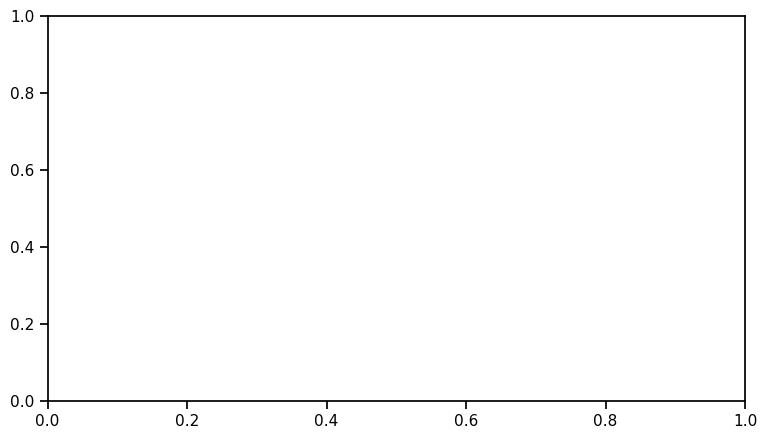

In [17]:
# -- Estación A --------------------------------------------------------------
hovmoller_station(
    nc_bay, gr_bay,
    station=(300, 136),
    varname='W',
    subtract=True,
    nc_nobay=nc_nobay,
    vmin=-1e-5, vmax=1e-5,
    title_suffix='(bay − noBay)'
)



In [22]:
station=(300, 136)
j, i = station
hours_offset = 2.5
t_all = nc_bay.variables['T'][:] / 3600.0
RC    = gr_bay.variables['RC'][:]
idx0  = np.where(t_all >= hours_offset)[0][0] if hours_offset>0 else 0
t     = t_all[idx0:]

In [25]:
W_bay = nc_bay.variables['W'][:, :, j, i]
W_nobay = nc_nobay.variables['W'][:, :, j, i]
W_diff = W_bay - W_nobay
W_diff = W_diff[idx0:, :]
vmax = np.nanmax(W_diff)
vmin = -vmax


TypeError: Dimensions of C (259, 90) should be one smaller than X(259) and Y(90) while using shading='flat' see help(pcolormesh)

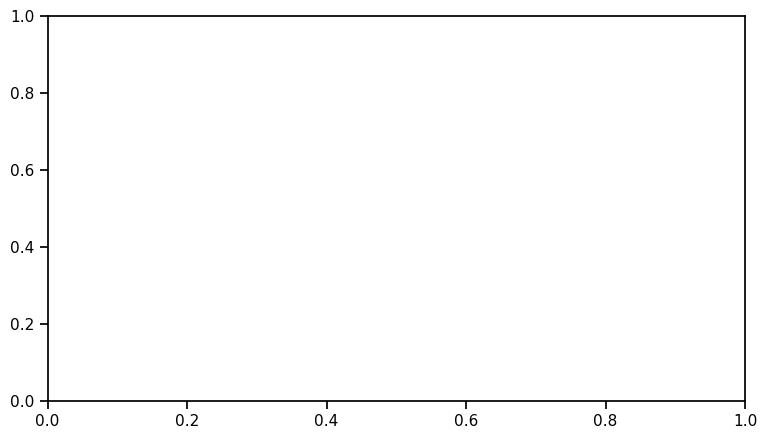

In [27]:
fig, ax = plt.subplots(figsize=(9, 5))
mesh = ax.pcolormesh(t, RC, W_diff, cmap=cmo.cm.balance,
                        vmin=vmin, vmax=vmax)
fig.colorbar(mesh, ax=ax, label='W (m/s)')
ax.set_xlabel('Tiempo (h)')
ax.set_ylabel('Profundidad (m)')
ax.set_title(f'Hovmöller W_diff Estación (j={j}, i={i})')
plt.show()